# Segment the adult dataset using GOWER similarity and DBScan Clustering

In [1]:
%matplotlib inline

import pandas as pd
import pylab
import numpy as np
import seaborn as sns
from feature_engine.encoding import RareLabelEncoder
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import linear_model
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import gower

# Import Data
the dataset is available here: https://archive.ics.uci.edu/ml/datasets/adult

In [2]:

try:
        # load the local dataset 
        df = pd.read_csv('../data/adult_dataset.csv')
except:
        # load the dataset from uci
        features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
                "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
                "Hours per week", "Country", "Target"] 

        # Change these to local file if available
        train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
        test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

        # This will download 3.8M
        original_train = pd.read_csv(train_url, names=features, sep=r'\s*,\s*', 
                                engine='python', na_values="?")
        # This will download 1.9M
        original_test = pd.read_csv(test_url, names=features, sep=r'\s*,\s*', 
                                engine='python', na_values="?", skiprows=1)

        # combine both datasets
        df = pd.concat([original_train, original_test], axis=0)
        # save the data locally
        df.to_csv('../data/adult_dataset.csv', index=False)                            

In [3]:
df.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
# Relabel taget colum since there is no target in unsupervised learning
df.rename(columns={"Target": "Income"}, inplace=True)

# Train-Test Split the Data

In [5]:
df.shape

(48842, 15)

In [6]:
# way too much data for training; let´s split the data
X_train, X_test = train_test_split(df, test_size=0.75, random_state=123)

In [7]:
X_train.shape

(12210, 15)

In [8]:
X_test.shape

(36632, 15)

In [9]:
X_train.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Income
26763,63,Private,124242,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,Black,Male,0,0,40,United-States,<=50K
32676,26,Private,206721,HS-grad,9,Never-married,Handlers-cleaners,Unmarried,White,Male,0,0,40,United-States,<=50K.
27426,18,NaN,348588,12th,8,Never-married,NaN,Own-child,Black,Male,0,0,25,United-States,<=50K
29074,26,Private,68991,HS-grad,9,Never-married,Other-service,Unmarried,Black,Male,0,0,40,United-States,<=50K
30398,61,Private,103575,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,37,United-States,<=50K


# Exploratory Data Analysis

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12210 entries, 26763 to 15725
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             12210 non-null  int64 
 1   Workclass       11485 non-null  object
 2   fnlwgt          12210 non-null  int64 
 3   Education       12210 non-null  object
 4   Education-Num   12210 non-null  int64 
 5   Martial Status  12210 non-null  object
 6   Occupation      11484 non-null  object
 7   Relationship    12210 non-null  object
 8   Race            12210 non-null  object
 9   Sex             12210 non-null  object
 10  Capital Gain    12210 non-null  int64 
 11  Capital Loss    12210 non-null  int64 
 12  Hours per week  12210 non-null  int64 
 13  Country         12001 non-null  object
 14  Income          12210 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.5+ MB


In [11]:
X_train.isna().sum()

Age                 0
Workclass         725
fnlwgt              0
Education           0
Education-Num       0
Martial Status      0
Occupation        726
Relationship        0
Race                0
Sex                 0
Capital Gain        0
Capital Loss        0
Hours per week      0
Country           209
Income              0
dtype: int64

## Impute Missing Values

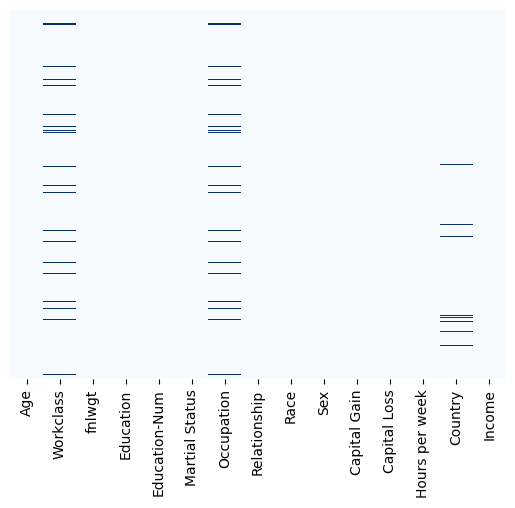

In [12]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(X_train.isna(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

In [13]:
# get numeric and categorical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [14]:
numeric_columns = X_train.select_dtypes(include=numerics).columns.to_list()
numeric_columns

['Age',
 'fnlwgt',
 'Education-Num',
 'Capital Gain',
 'Capital Loss',
 'Hours per week']

In [15]:
categorical_columns = X_train.select_dtypes(exclude=numerics).columns.to_list()
categorical_columns

['Workclass',
 'Education',
 'Martial Status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Country',
 'Income']

In [16]:
# Impute missing numeric values
numeric_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_numeric = numeric_imputer.fit_transform(X_train.select_dtypes(include=numerics))
X_train_numeric = pd.DataFrame(X_train_numeric, columns=numeric_columns, index=X_train.index)
X_train_numeric.head()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week
26763,63.0,124242.0,9.0,0.0,0.0,40.0
32676,26.0,206721.0,9.0,0.0,0.0,40.0
27426,18.0,348588.0,8.0,0.0,0.0,25.0
29074,26.0,68991.0,9.0,0.0,0.0,40.0
30398,61.0,103575.0,9.0,0.0,0.0,37.0


In [17]:
# Impute missing numeric values
categorical_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train_categorical = categorical_imputer.fit_transform(X_train.select_dtypes(exclude=numerics))
X_train_categorical = pd.DataFrame(X_train_categorical, columns=categorical_columns, index=X_train.index)
X_train_categorical.head()

,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income
26763,Private,HS-grad,Married-civ-spouse,Adm-clerical,Husband,Black,Male,United-States,<=50K
32676,Private,HS-grad,Never-married,Handlers-cleaners,Unmarried,White,Male,United-States,<=50K.
27426,Private,12th,Never-married,Exec-managerial,Own-child,Black,Male,United-States,<=50K
29074,Private,HS-grad,Never-married,Other-service,Unmarried,Black,Male,United-States,<=50K
30398,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K


In [18]:
X_train = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_train.head()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income
26763,63.0,124242.0,9.0,0.0,0.0,40.0,Private,HS-grad,Married-civ-spouse,Adm-clerical,Husband,Black,Male,United-States,<=50K
32676,26.0,206721.0,9.0,0.0,0.0,40.0,Private,HS-grad,Never-married,Handlers-cleaners,Unmarried,White,Male,United-States,<=50K.
27426,18.0,348588.0,8.0,0.0,0.0,25.0,Private,12th,Never-married,Exec-managerial,Own-child,Black,Male,United-States,<=50K
29074,26.0,68991.0,9.0,0.0,0.0,40.0,Private,HS-grad,Never-married,Other-service,Unmarried,Black,Male,United-States,<=50K
30398,61.0,103575.0,9.0,0.0,0.0,37.0,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K


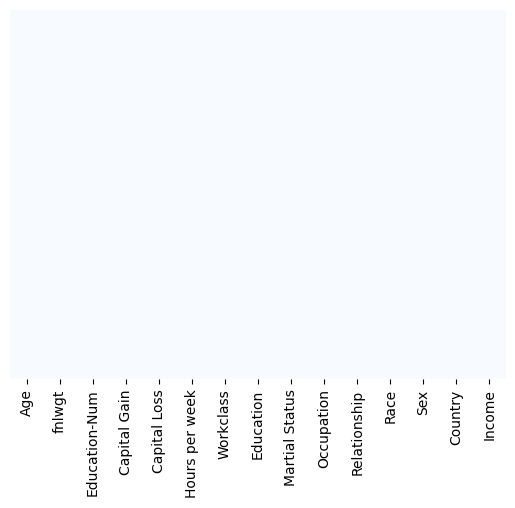

In [19]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(X_train.isna(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

## Visualize Categorical Features

In [20]:
# this is important since we might have rare labels which isnt good for grouping customers; the numeric equivalent would be outliers
for category in categorical_columns:
    print('Value counts in category {}: \n{}'.format(category, X_train[category].value_counts()))

Value counts in category Workclass: 
Private             9136
Self-emp-not-inc     971
Local-gov            839
State-gov            500
Self-emp-inc         435
Federal-gov          324
Without-pay            4
Never-worked           1
Name: Workclass, dtype: int64
Value counts in category Education: 
HS-grad         3923
Some-college    2688
Bachelors       2026
Masters          670
Assoc-voc        527
11th             461
Assoc-acdm       411
10th             337
7th-8th          230
9th              202
Prof-school      199
12th             166
Doctorate        153
5th-6th          123
1st-4th           73
Preschool         21
Name: Education, dtype: int64
Value counts in category Martial Status: 
Married-civ-spouse       5586
Never-married            4032
Divorced                 1645
Separated                 389
Widowed                   372
Married-spouse-absent     172
Married-AF-spouse          14
Name: Martial Status, dtype: int64
Value counts in category Occupation: 
Exec-

## Encode Rare Labels

In [21]:
rare_encoder = RareLabelEncoder(tol=0.05, n_categories=10)
X_train[categorical_columns] = rare_encoder.fit_transform(X_train[categorical_columns])
X_train[categorical_columns].head()

c:\Users\Sebas\anaconda3\envs\aws_sagemaker\lib\site-packages\feature_engine\encoding\rare_label.py:199: UserWarning: The number of unique categories for variable Workclass is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\Sebas\anaconda3\envs\aws_sagemaker\lib\site-packages\feature_engine\encoding\rare_label.py:199: UserWarning: The number of unique categories for variable Martial Status is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\Sebas\anaconda3\envs\aws_sagemaker\lib\site-packages\feature_engine\encoding\rare_label.py:199: UserWarning: The number of unique categories for variable Relationship is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\Sebas\anaconda3\envs\aws_sagemaker\lib\site-packages\feature_engine\encoding\rare_label.py:199: UserWarning: The number of unique c

,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income
26763,Private,HS-grad,Married-civ-spouse,Adm-clerical,Husband,Black,Male,United-States,<=50K
32676,Private,HS-grad,Never-married,Rare,Unmarried,White,Male,United-States,<=50K.
27426,Private,Rare,Never-married,Exec-managerial,Own-child,Black,Male,United-States,<=50K
29074,Private,HS-grad,Never-married,Other-service,Unmarried,Black,Male,United-States,<=50K
30398,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K


## Visualize Numerical Features

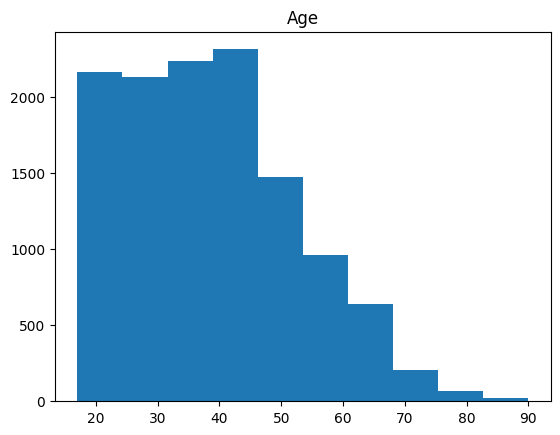

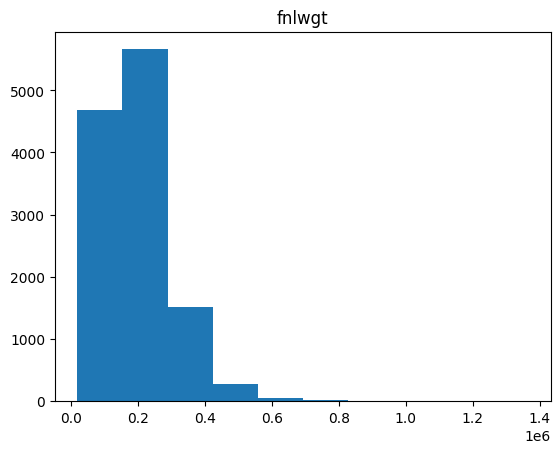

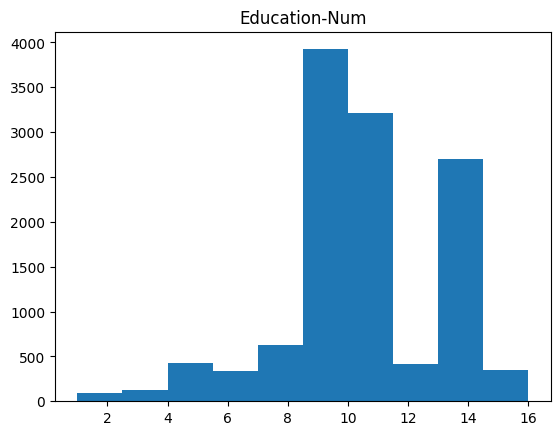

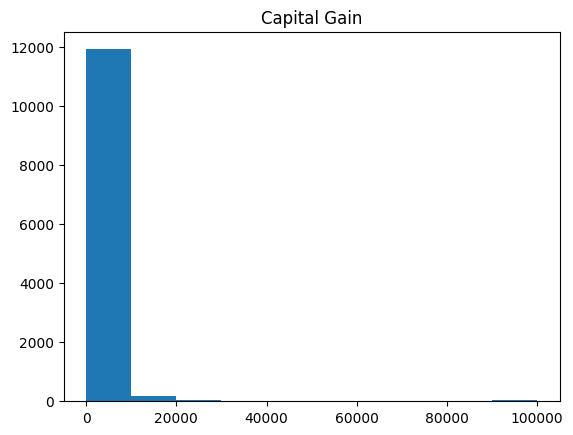

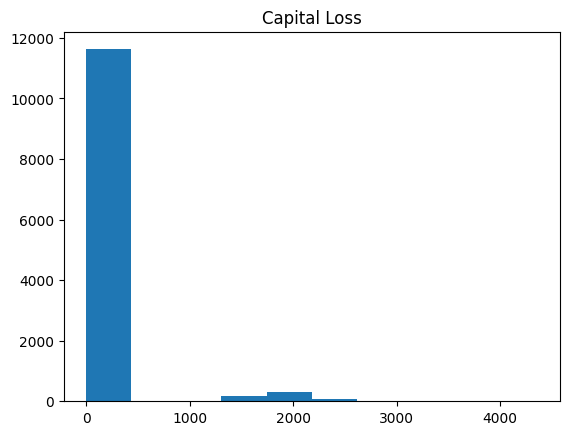

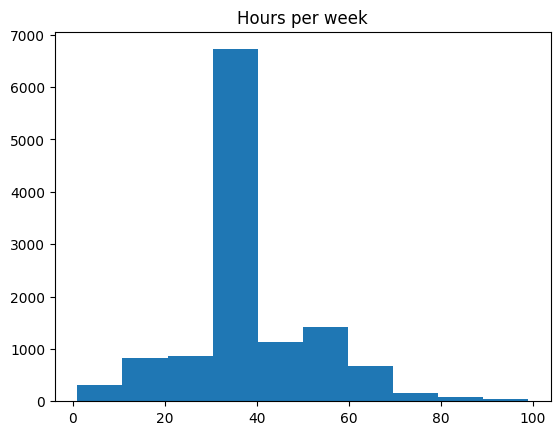

In [22]:
# plot the distributions
for col in numeric_columns:
    plt.hist(X_train[col])
    plt.title(col)
    plt.show()

## Remove Outliers

In [23]:
from feature_engine.outliers import Winsorizer

In [24]:
# set up the capper
capper = Winsorizer(
    capping_method='gaussian', 
    tail='right', 
    fold=3, 
    variables=numeric_columns)

In [25]:
# fit the capper
X_train[numeric_columns] = capper.fit_transform(X_train[numeric_columns])
X_train.head()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income
26763,63.0,124242.0,9.0,0.0,0.0,40.0,Private,HS-grad,Married-civ-spouse,Adm-clerical,Husband,Black,Male,United-States,<=50K
32676,26.0,206721.0,9.0,0.0,0.0,40.0,Private,HS-grad,Never-married,Rare,Unmarried,White,Male,United-States,<=50K.
27426,18.0,348588.0,8.0,0.0,0.0,25.0,Private,Rare,Never-married,Exec-managerial,Own-child,Black,Male,United-States,<=50K
29074,26.0,68991.0,9.0,0.0,0.0,40.0,Private,HS-grad,Never-married,Other-service,Unmarried,Black,Male,United-States,<=50K
30398,61.0,103575.0,9.0,0.0,0.0,37.0,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K


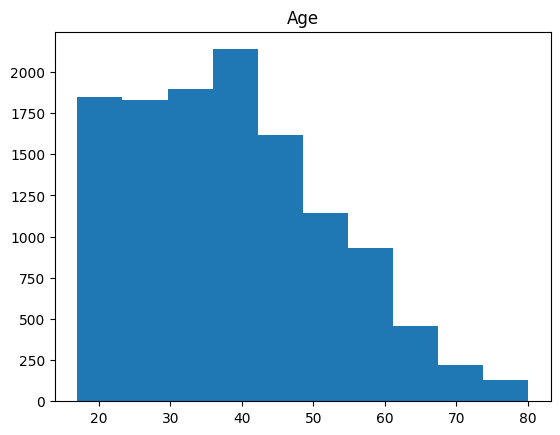

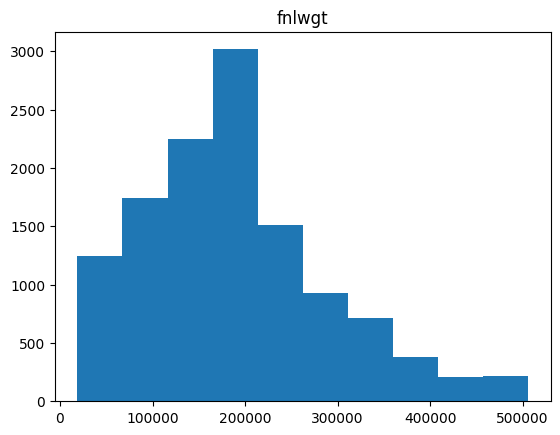

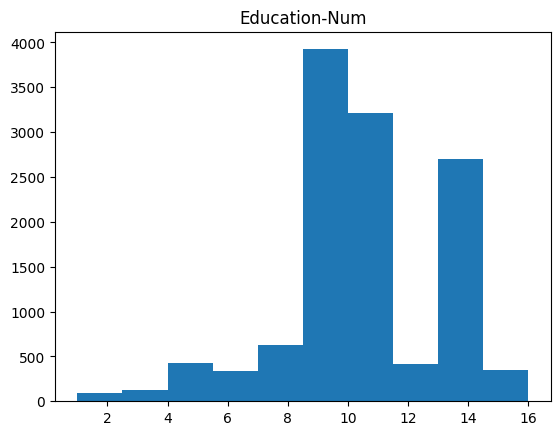

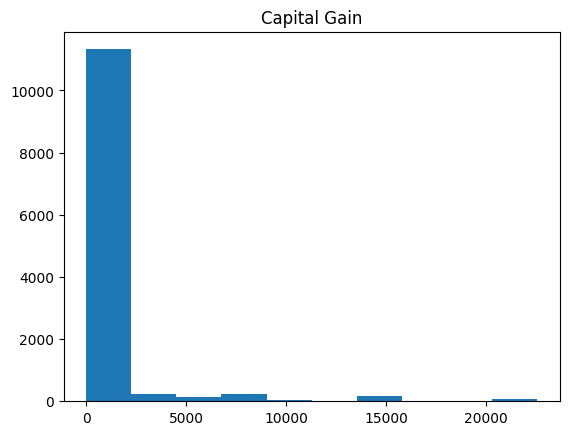

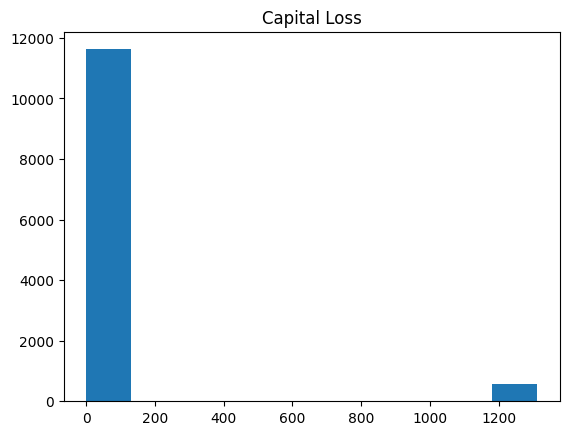

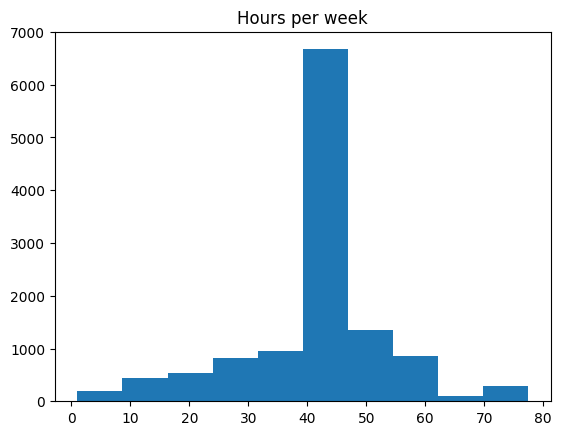

In [26]:
# plot the distributions
for col in numeric_columns:
    plt.hist(X_train[col])
    plt.title(col)
    plt.show()

# Calculate Customer Similarity using Gower´s Distance

In [27]:
%%time
distance_matrix = gower.gower_matrix(X_train)

CPU times: total: 4min 43s
Wall time: 4min 55s


In [28]:
distance_matrix.shape

(12210, 12210)

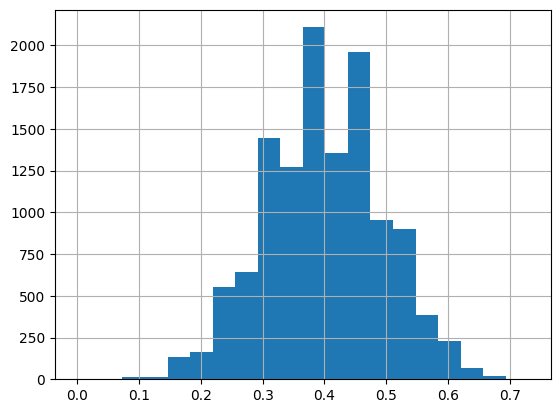

In [29]:
customer = 3
plt.hist(distance_matrix[:,customer], bins=20)
plt.grid()
plt.show()

In [30]:
# let´s choose a cut-off gower´s distance of e.g. 0.2
gower_cutoff = 0.2  

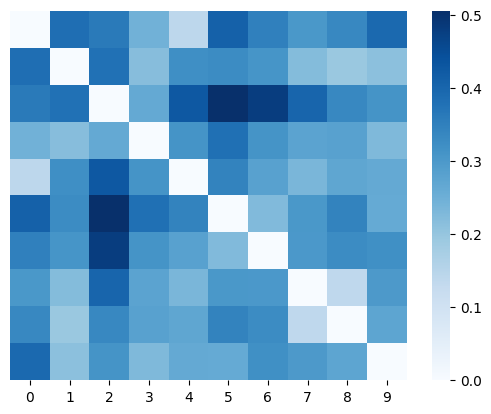

In [31]:
# plot the similarity matrix as heatmap
sns.heatmap(
    distance_matrix[:10,:10], 
    yticklabels = False, 
    cbar = True, 
    cmap="Blues")
plt.show()

In [32]:
# find the top-n customers similar to a particular customer
customer=100
top_n = gower.gower_topn(
    X_train.iloc[customer:customer+1,:], 
    X_train.iloc[:,], 
    n = 5)
top_n

{'index': array([ 100, 1626, 4014, 7010, 6219], dtype=int64),
 'values': array([0.        , 0.02376317, 0.0356093 , 0.07768197, 0.08221891],
       dtype=float32)}

In [33]:
top_n['index']

array([ 100, 1626, 4014, 7010, 6219], dtype=int64)

In [34]:
X_train.iloc[top_n['index'],:]

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income
1819,43.0,206139.0,13.0,0.0,0.0,50.0,State-gov,Bachelors,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States,>50K
24170,41.0,47902.0,13.0,0.0,0.0,50.0,State-gov,Bachelors,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States,>50K
4808,49.0,55938.0,13.0,0.0,0.0,40.0,State-gov,Bachelors,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States,>50K
12255,47.0,188386.0,13.0,0.0,0.0,45.0,State-gov,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,>50K
31008,47.0,187087.0,13.0,0.0,0.0,40.0,State-gov,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,>50K


# DBScan Clustering

In [35]:
from sklearn.cluster import DBSCAN

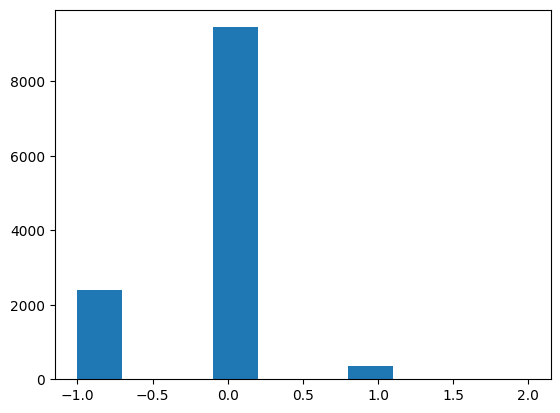

CPU times: total: 1.8 s
Wall time: 1.84 s


In [71]:
%%time
# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.1, 
                        min_samples=25, 
                        metric="precomputed",
                        n_jobs=-1)

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)

plt.hist(dbscan_cluster.labels_) 
#plt.ylim(0,1000)
plt.show()

In [72]:
# Compute Cluster Quality using Silhouette Score
from sklearn.metrics import silhouette_score

silhouette_score(X=distance_matrix, labels=dbscan_cluster.labels_, metric="precomputed")

0.00208579

In [92]:
%%time
# lets try different hyperparameters and count the cluster numbers; we dont want like 100 cluster but we do want maybe more than 2 clusters

results_list = []
eps_range = np.arange(.05, 0.25, .025)
min_sample_range = np.arange(5, 50, 5)

for eps in eps_range:
    for min_samples in min_sample_range:

        # Configuring the parameters of the clustering algorithm
        dbscan_cluster = DBSCAN(eps=eps, 
                                min_samples=min_samples, 
                                metric="precomputed",
                                n_jobs=-1)

        # Fitting the clustering algorithm
        dbscan_cluster.fit(distance_matrix)

        # count the number of clusters different from noise i.e. labeled -1
        num_cluster_detected = len(np.unique(dbscan_cluster.labels_[np.where(dbscan_cluster.labels_ >= 0)]))
        # count the number of datapoints i.e. customers labeled as noise i.e. -1
        num_noise_data = list(dbscan_cluster.labels_).count(-1)
        # calculate cluster quality using the silhouette score
        cluster_quality = silhouette_score(X=distance_matrix, 
                                           labels=dbscan_cluster.labels_, 
                                           metric="precomputed")
        

        # save results
        results_list.append([eps, min_samples, cluster_quality, num_cluster_detected, num_noise_data])

CPU times: total: 3min 38s
Wall time: 3min 44s


In [94]:
results_list

[[0.05, 5, -0.04950045, 454, 6208],
 [0.05, 10, -0.20250568, 195, 7965],
 [0.05, 15, -0.29111484, 109, 9049],
 [0.05, 20, -0.34018758, 70, 9734],
 [0.05, 25, -0.34717038, 44, 10334],
 [0.05, 30, -0.3670943, 28, 10781],
 [0.05, 35, -0.36338887, 20, 11062],
 [0.05, 40, -0.3674615, 14, 11300],
 [0.05, 45, -0.29261324, 10, 11478],
 [0.07500000000000001, 5, -0.4044195, 50, 4196],
 [0.07500000000000001, 10, -0.23629917, 11, 5502],
 [0.07500000000000001, 15, 0.06390938, 2, 6269],
 [0.07500000000000001, 20, -0.022138186, 3, 6907],
 [0.07500000000000001, 25, -0.042076457, 3, 7471],
 [0.07500000000000001, 30, -0.11055137, 4, 8022],
 [0.07500000000000001, 35, -0.13717553, 4, 8561],
 [0.07500000000000001, 40, -0.18467535, 5, 9022],
 [0.07500000000000001, 45, -0.1347568, 3, 9491],
 [0.10000000000000002, 5, 0.056895193, 3, 1238],
 [0.10000000000000002, 10, 0.1605949, 1, 1566],
 [0.10000000000000002, 15, 0.15271658, 1, 1817],
 [0.10000000000000002, 20, 0.058619842, 2, 2118],
 [0.10000000000000002, 25

In [96]:
clustering_results_df = pd.DataFrame(results_list, columns = ("eps", "min_samples", "cluster_quality", "num_clusters", "num_noise_data"))
clustering_results_df

,eps,min_samples,cluster_quality,num_clusters,num_noise_data
0,0.050,5,-0.049500,454,6208
1,0.050,10,-0.202506,195,7965
2,0.050,15,-0.291115,109,9049
3,0.050,20,-0.340188,70,9734
4,0.050,25,-0.347170,44,10334
...,...,...,...,...,...
67,0.225,25,0.285779,1,12
68,0.225,30,0.291887,1,14
69,0.225,35,0.290596,1,15
70,0.225,40,0.291112,1,18


In [155]:
nclusters = 4
db_config = clustering_results_df[clustering_results_df["num_clusters"] == nclusters].sort_values(by="cluster_quality", ascending=False)
db_config 

,eps,min_samples,cluster_quality,num_clusters,num_noise_data
14,0.075,30,-0.110551,4,8022
15,0.075,35,-0.137176,4,8561


0.075 30


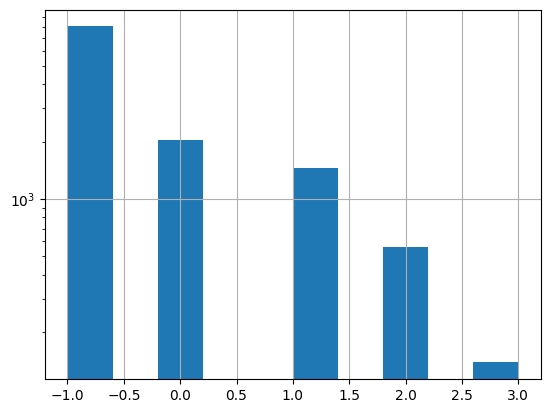

0.075 35


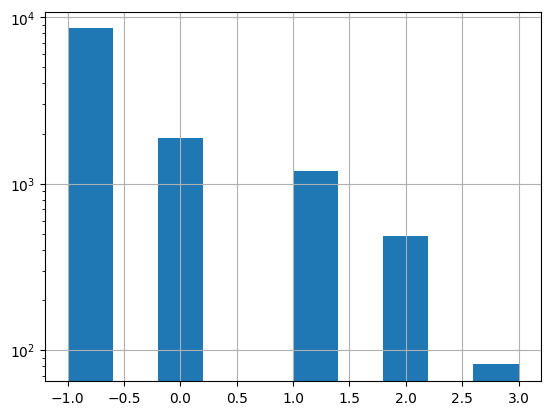

In [156]:
for conf in np.array(db_config[['eps', 'min_samples']]):
    eps = np.round(conf[0],3)
    min_samples = int(conf[1])
    print(eps, min_samples)

    # Configuring the parameters of the clustering algorithm
    dbscan_cluster = DBSCAN(eps=eps, 
                            min_samples=min_samples, 
                            metric="precomputed",
                            n_jobs=-1)

    # Fitting the clustering algorithm
    dbscan_cluster.fit(distance_matrix)

    plt.hist(dbscan_cluster.labels_) 
    plt.yscale('log')
    plt.grid()
    plt.show()

In [191]:
# Adding the results to a new column in the dataframe
X_train["cluster"] = dbscan_cluster.labels_
X_train.head()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income,cluster
26763,63.0,124242.0,9.0,0.0,0.0,40.0,Private,HS-grad,Married-civ-spouse,Adm-clerical,Husband,Black,Male,United-States,<=50K,0
32676,26.0,206721.0,9.0,0.0,0.0,40.0,Private,HS-grad,Never-married,Rare,Unmarried,White,Male,United-States,<=50K.,1
27426,18.0,348588.0,8.0,0.0,0.0,25.0,Private,Rare,Never-married,Exec-managerial,Own-child,Black,Male,United-States,<=50K,-1
29074,26.0,68991.0,9.0,0.0,0.0,40.0,Private,HS-grad,Never-married,Other-service,Unmarried,Black,Male,United-States,<=50K,-1
30398,61.0,103575.0,9.0,0.0,0.0,37.0,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K,0


(array([101.,  70.,  36.,  12.,   6.,   2.,   3.,   0.,   0.,   1.]),
 array([21.        , 26.90841927, 32.81683855, 38.72525782, 44.6336771 ,
        50.54209637, 56.45051564, 62.35893492, 68.26735419, 74.17577347,
        80.08419274]),
 <BarContainer object of 10 artists>)

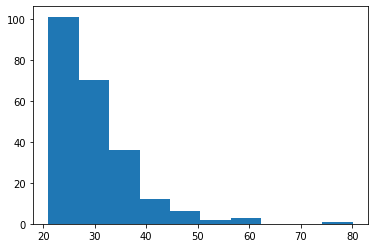

In [198]:
# Visualize the Clusters
cluster = 2
plt.hist(X_train[X_train['cluster']==cluster]['Age'])  

In [203]:
len(dbscan_cluster.labels_)

12210

In [205]:
numeric_columns

['Age',
 'fnlwgt',
 'Education-Num',
 'Capital Gain',
 'Capital Loss',
 'Hours per week']

In [206]:
# Plot the histogram of various clusters
for i in numeric_columns:
  plt.figure(figsize = (35, 5))
  for j in np.array([-1, 0, 1]):
    plt.subplot(1, len(np.array([-1, 0, 1])), j+1)
    cluster = X_train[X_train['cluster'] == j][i]
    cluster[i].hist(bins = 20)
    plt.title('{}    \nCluster {} '.format(i,j))
  
  plt.show()

ValueError: num must be 1 <= num <= 3, not 0

<Figure size 2520x360 with 0 Axes>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [4]:
# You have to include the full link to the csv file containing your dataset
df = pd.read_csv('../data/Marketing_data.csv')
df.head()
# CUSTID: Identification of Credit Card holder 
# BALANCE: Balance amount left in customer's account to make purchases
# BALANCE_FREQUENCY: How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
# PURCHASES: Amount of purchases made from account
# ONEOFFPURCHASES: Maximum purchase amount done in one-go
# INSTALLMENTS_PURCHASES: Amount of purchase done in installment
# CASH_ADVANCE: Cash in advance given by the user
# PURCHASES_FREQUENCY: How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
# ONEOFF_PURCHASES_FREQUENCY: How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
# PURCHASES_INSTALLMENTS_FREQUENCY: How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
# CASH_ADVANCE_FREQUENCY: How frequently the cash in advance being paid
# CASH_ADVANCE_TRX: Number of Transactions made with "Cash in Advance"
# PURCHASES_TRX: Number of purchase transactions made
# CREDIT_LIMIT: Limit of Credit Card for user
# PAYMENTS: Amount of Payment done by user
# MINIMUM_PAYMENTS: Minimum amount of payments made by user  
# PRC_FULL_PAYMENT: Percent of full payment paid by user
# TENURE: Tenure of credit card service for user

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [5]:
df.info()
# 18 features with 8950 points  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [6]:
df.describe()
# Mean balance is $1564 
# Balance frequency is frequently updated on average ~0.9
# Purchases average is $1000
# one off purchase average is ~$600
# Average purchases frequency is around 0.5
# average ONEOFF_PURCHASES_FREQUENCY, PURCHASES_INSTALLMENTS_FREQUENCY, and CASH_ADVANCE_FREQUENCY are generally low
# Average credit limit ~ 4500
# Percent of full payment is 15%
# Average tenure is 11 years

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


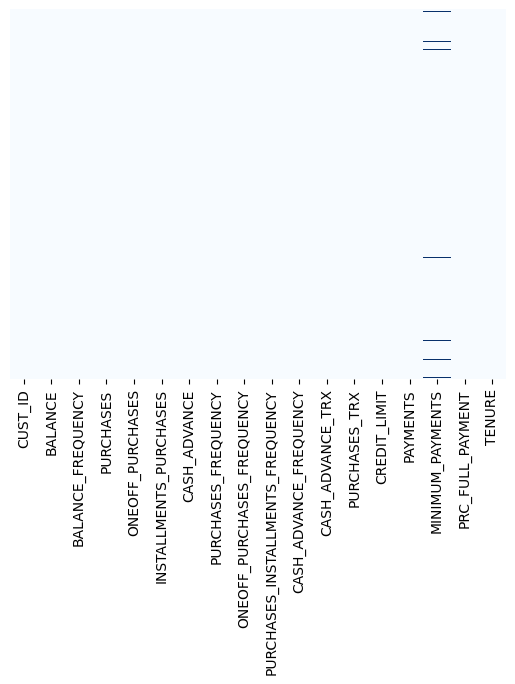

In [7]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

In [8]:
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [9]:
# Fill up the missing elements with mean of the 'MINIMUM_PAYMENT' 
df.loc[(df['MINIMUM_PAYMENTS'].isnull() == True), 'MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].mean()


In [10]:
# Fill up the missing elements with mean of the 'CREDIT_LIMIT' 
df.loc[(df['CREDIT_LIMIT'].isnull() == True), 'CREDIT_LIMIT'] = df['CREDIT_LIMIT'].mean()

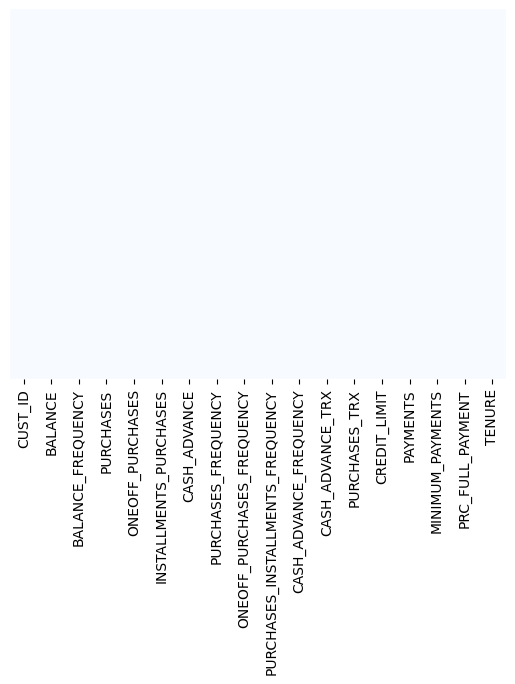

In [11]:
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

In [12]:
# Let's see if we have duplicated entries in the data
df.duplicated().sum()

0

In [13]:
# Let's drop Customer ID since it has no meaning here 
df.drop("CUST_ID", axis = 1, inplace= True)

In [14]:
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [15]:
n = len(df.columns)
n

17

In [16]:
df.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

C:\Users\Sebas\AppData\Local\Temp\ipykernel_8920\556246996.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df.columns[i]],
c:\Users\Sebas\anaconda3\envs\aws_sagemaker\lib\site-packages\seaborn\distributions.py:2511: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_8920\556246996.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed i

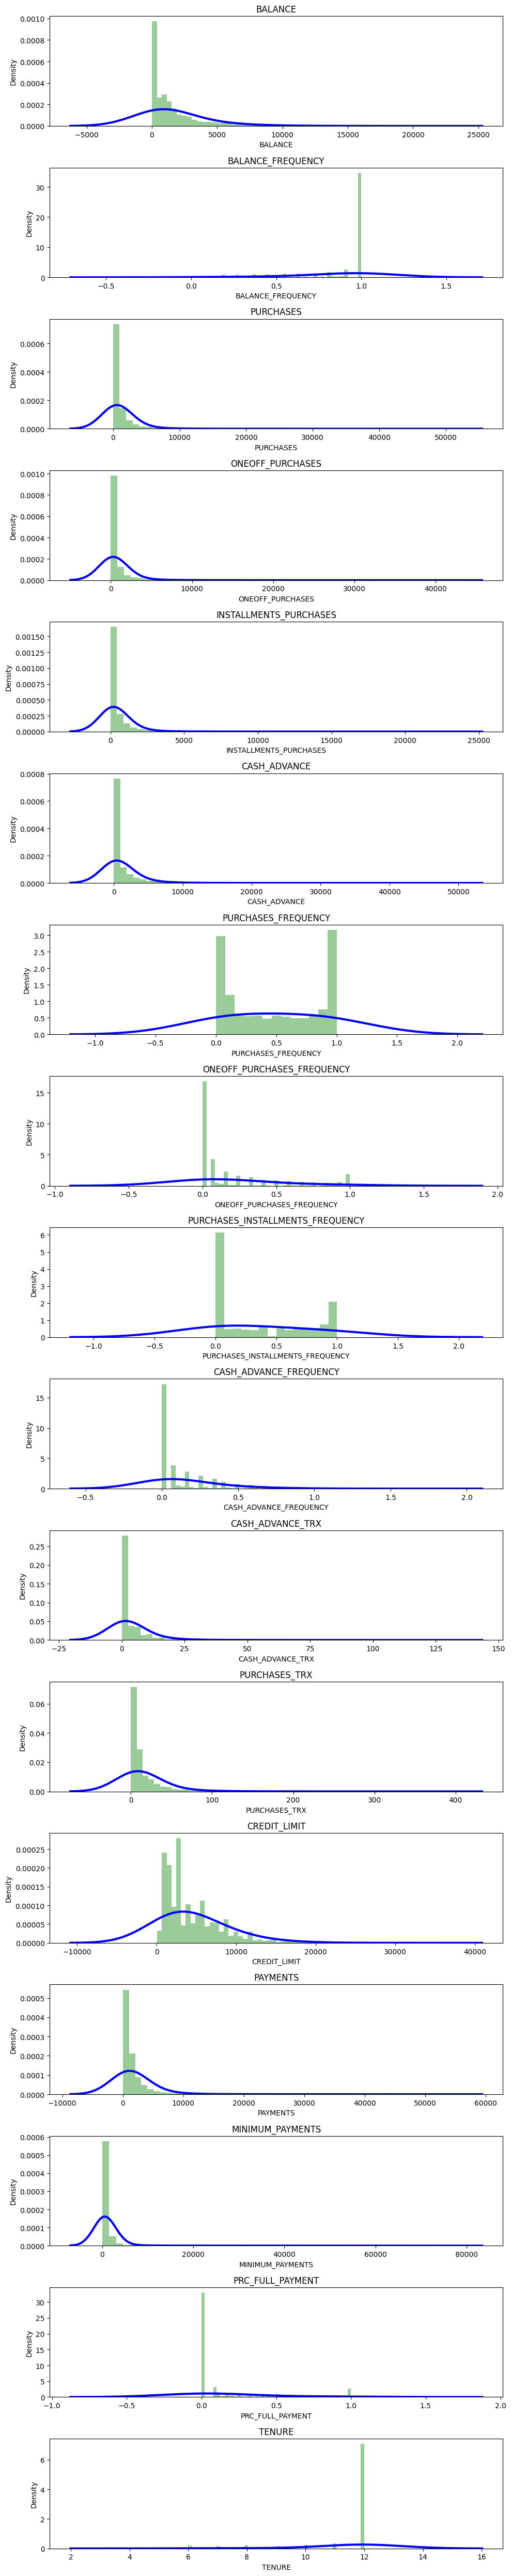

In [17]:
# distplot combines the matplotlib.hist function with seaborn kdeplot()
# KDE Plot represents the Kernel Density Estimate
# KDE is used for visualizing the Probability Density of a continuous variable. 
# KDE demonstrates the probability density at different values in a continuous variable. 

# Mean of balance is $1500
# 'Balance_Frequency' for most customers is updated frequently ~1
# For 'PURCHASES_FREQUENCY', there are two distinct group of customers
# For 'ONEOFF_PURCHASES_FREQUENCY' and 'PURCHASES_INSTALLMENT_FREQUENCY' most users don't do one off puchases or installment purchases frequently 
# Very small number of customers pay their balance in full 'PRC_FULL_PAYMENT'~0
# Credit limit average is around $4500
# Most customers are ~11 years tenure

plt.figure(figsize=(10,50))
for i in range(len(df.columns)):
  plt.subplot(17, 1, i+1)
  sns.distplot(df[df.columns[i]], 
               kde_kws={"color": "b", "lw": 3, "label": "KDE", 'bw': 1},
               hist_kws={"color": "g"})
  plt.title(df.columns[i])

plt.tight_layout()
plt.show()

In [18]:
# sns.pairplot(creditcard_df)
# Correlation between 'PURCHASES' and ONEOFF_PURCHASES & INSTALMENT_PURCHASES 
# Trend between 'PURCHASES' and 'CREDIT_LIMIT' & 'PAYMENTS'


In [19]:
correlations = df.corr()


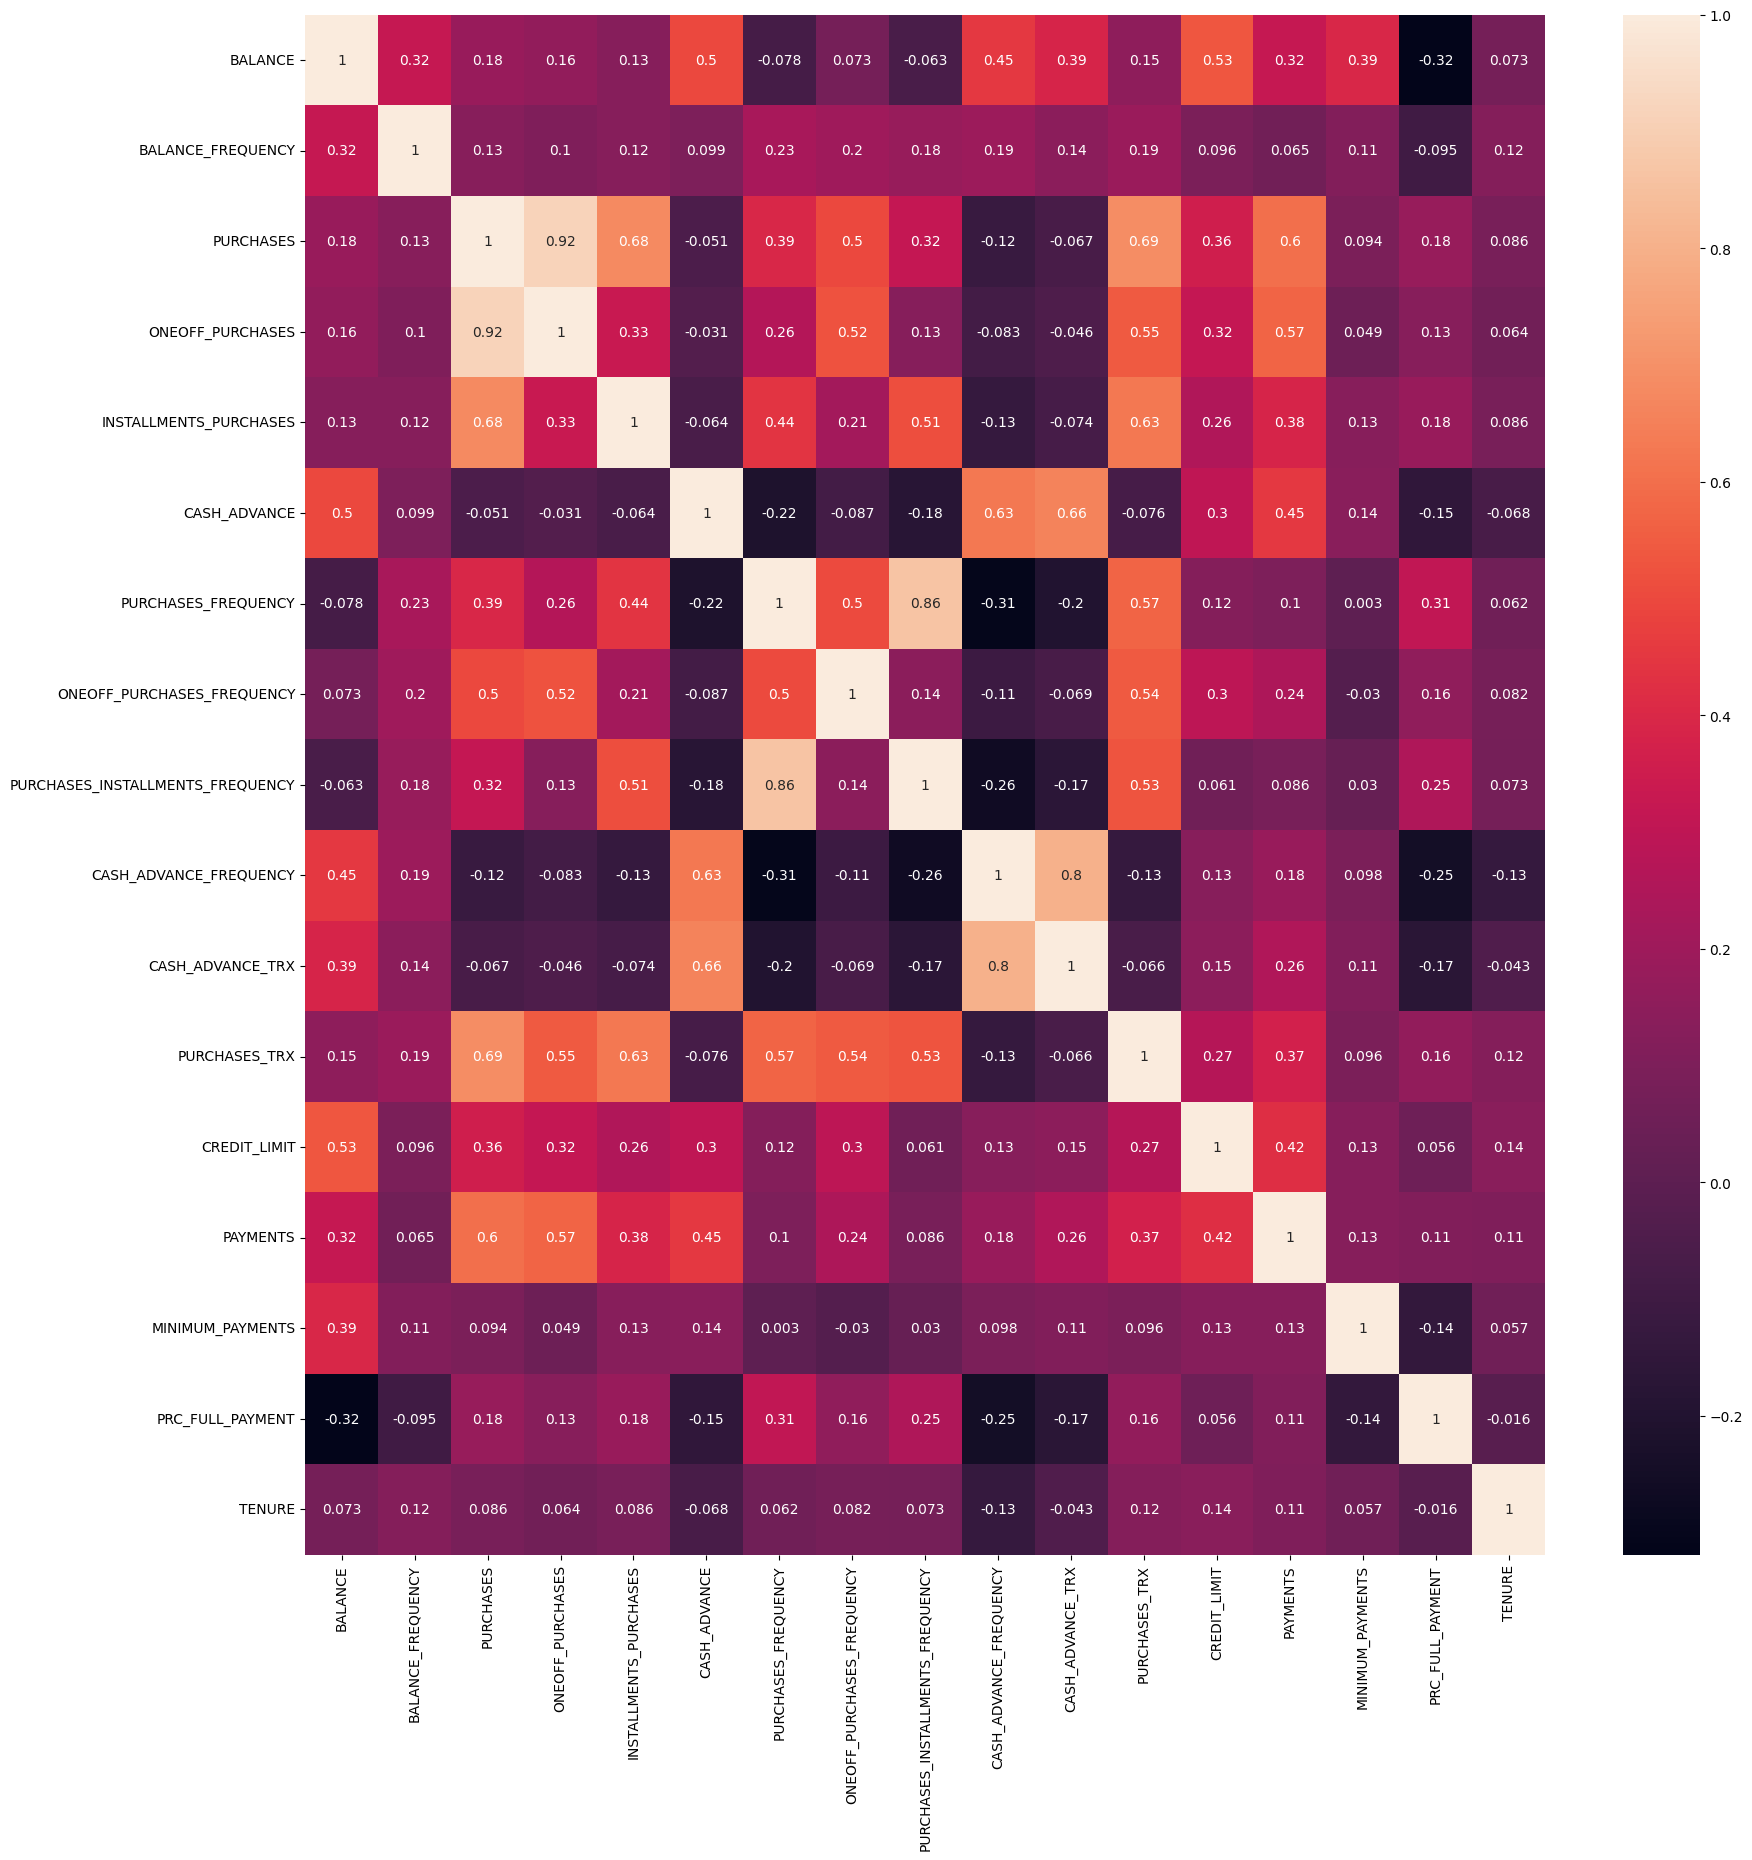

In [20]:
f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(correlations, annot = True)
plt.show()
# 'PURCHASES' have high correlation between one-off purchases, 'installment purchases, purchase transactions, credit limit and payments. 
# Strong Positive Correlation between 'PURCHASES_FREQUENCY' and 'PURCHASES_INSTALLMENT_FREQUENCY'


## Conclusion
We got many features correlated! In order to come up with a meaningfull segmentation with interpretable results, we need to compress the feature space

# Train Test Split

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
df.head(3)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.0,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.0,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.0,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12


In [23]:
X_train, X_test = train_test_split(
    df, 
    test_size=0.33, 
    random_state=123
)

In [24]:
X_test.head(3)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
8884,5.911397,0.500000,0.00,0.00,0.0,19.712686,0.00,0.00,0.0,0.166667,1,0,500.0,32.355459,32.958244,0.500000,6
2771,2632.469367,1.000000,0.00,0.00,0.0,535.955512,0.00,0.00,0.0,0.250000,4,0,3000.0,737.932369,736.750992,0.000000,12
4345,4.054657,0.727273,264.02,264.02,0.0,0.000000,0.25,0.25,0.0,0.000000,0,4,7000.0,274.692435,55.272081,0.111111,12


# Scale Data

In [25]:
# in the first step we need to scale the data to
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled

array([[-0.74530512, -0.63358206, -0.40720687, ..., -0.31381157,
        -0.5217652 ,  0.36016455],
       [-0.49717266,  0.51712378, -0.15594327, ..., -0.23920979,
        -0.5217652 ,  0.36016455],
       [ 1.11381206,  0.51712378, -0.47579366, ..., -0.089764  ,
        -0.5217652 , -1.90667937],
       ...,
       [-0.49690947,  0.51712378,  1.88483137, ..., -0.28502659,
         2.629909  ,  0.36016455],
       [-0.43280043,  0.51712378, -0.20606986, ..., -0.26720225,
        -0.5217652 ,  0.36016455],
       [-0.68351358,  0.51712378,  0.1465091 , ..., -0.27958693,
         1.19732919,  0.36016455]])

In [26]:
X_train.shape

(5996, 17)

# PCA

In [27]:
# Obtain the optimal number of components

var_list = []
num_features = X_train.shape[1]
for n in range(1,num_features+1):
    pca = PCA(n_components=n)
    pca.fit(X_train_scaled)
    var_explained = pca.explained_variance_ratio_.cumsum()[-1]
    var_list.append(var_explained)

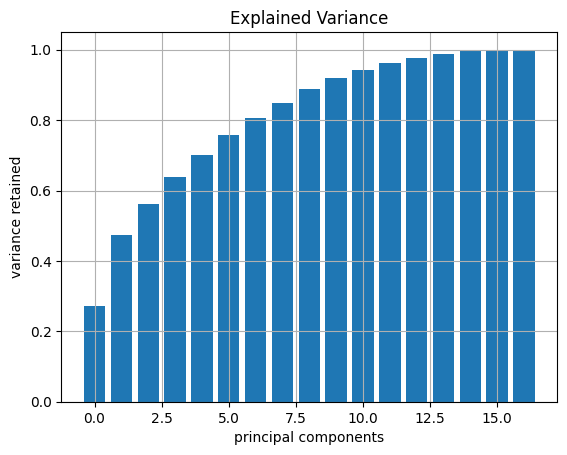

In [28]:
plt.bar(height=var_list, x=range(len(var_list)))
plt.grid()
plt.title('Explained Variance')
plt.xlabel('principal components')
plt.ylabel('variance retained')
plt.show()

In [29]:
# let´s choose 6 components in order to retain 80% of the variances
pca = PCA(n_components=5)
pca.fit(X_train_scaled)

PCA(n_components=5)

In [30]:
# show me the eigenvector as dataframe
pd.DataFrame(pca.components_, columns=list(X_train.columns), index=['pc#1','pc#2','pc#3','pc#4','pc#5'])

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
pc#1,0.107550,0.122480,0.411331,0.346153,0.328909,-0.019808,0.325278,0.298460,0.277582,-0.083222,-0.043418,0.392779,0.213248,0.259688,0.064415,0.132931,0.078037
pc#2,0.403439,0.126238,0.038084,0.062091,-0.027220,0.440024,-0.190735,-0.014592,-0.181124,0.434320,0.423075,-0.020580,0.231619,0.259513,0.162752,-0.191215,-0.011792
pc#3,-0.138184,-0.407140,0.268533,0.408328,-0.134939,-0.044635,-0.377322,0.121122,-0.479537,-0.132000,-0.139289,-0.060320,0.085966,0.273722,-0.198462,0.071422,-0.042841
pc#4,0.292588,0.190090,0.026983,0.058522,-0.047160,-0.251149,-0.164509,0.020155,-0.184958,-0.247735,-0.309419,-0.002214,0.119904,-0.142945,0.406773,-0.443013,0.439856
pc#5,0.055249,-0.491372,0.022921,-0.154471,0.351710,0.106637,-0.090836,-0.505035,0.169357,-0.152646,-0.092934,-0.053796,0.113087,0.199697,0.440522,0.148379,-0.021765


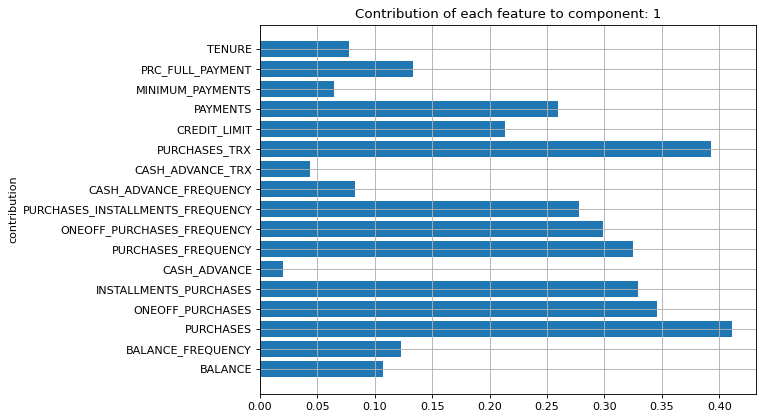

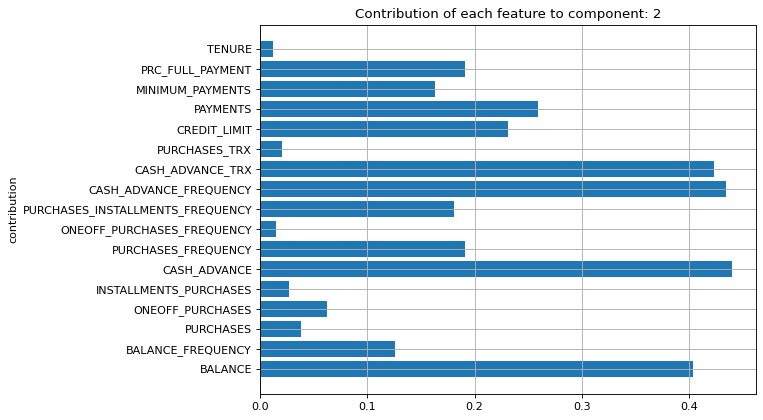

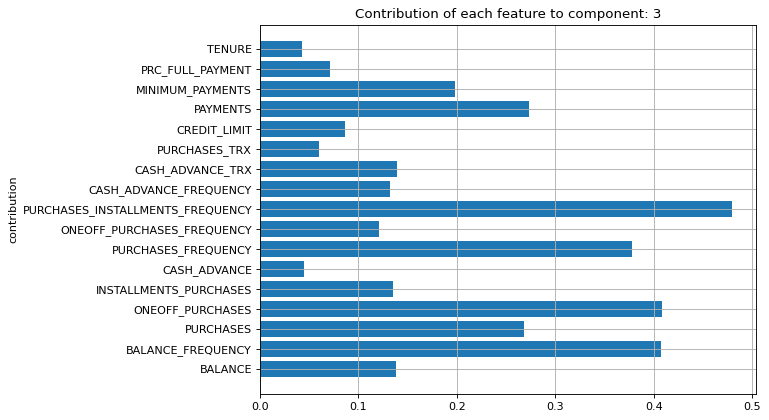

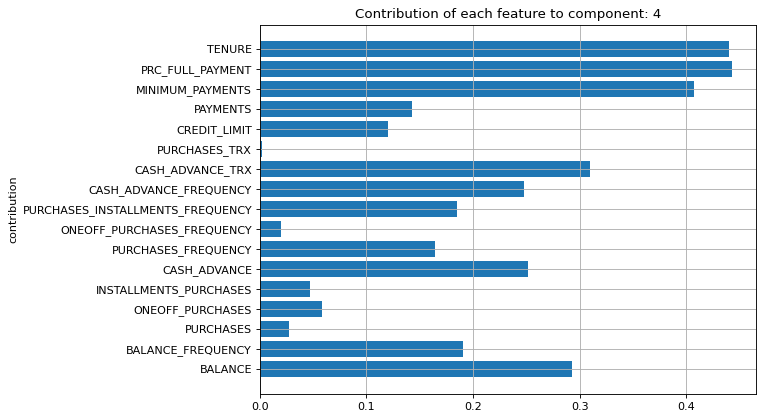

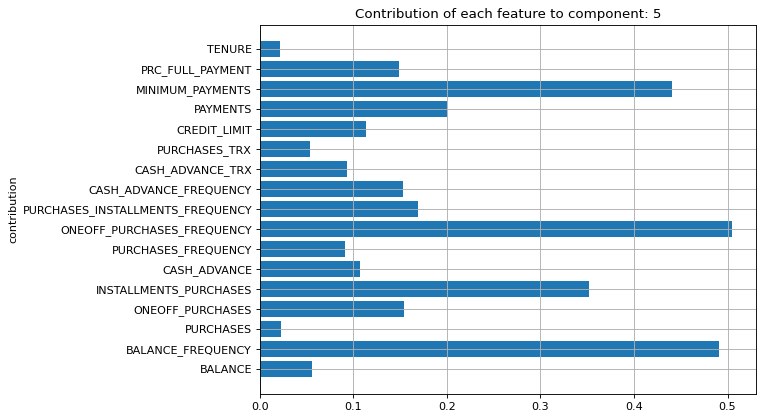

In [31]:
# get the eigenvectors in order to interpret the components

number_components = pca.components_.shape[0]
for component in range(0,number_components):

    #component = 4 # interprete component

    feature_contribution_df = pd.DataFrame(
        data=abs(pca.components_[component]), 
        index=X_train.columns, 
        columns=['feature contribution'])#.sort_values(by='feature contribution')

    plt.figure(figsize=(8, 6), dpi=80)
    plt.barh(width=feature_contribution_df.values.reshape(-1), y=feature_contribution_df.index)
    plt.title('Contribution of each feature to component: {}'.format(component+1))
    plt.ylabel('contribution')
    #plt.xlim(.4,.5)
    #plt.xticks(rotation = 90)
    plt.grid()
    plt.show()

In [32]:
# transform the scaled feature matrix 
X_train_scaled_pca = pca.transform(X_train_scaled)
X_train_scaled_pca


array([[-0.82238987, -1.63824907, -0.49578359,  0.07281336,  0.31880467],
       [ 0.30229173, -1.61267957, -1.72586496,  0.13310512,  0.11872667],
       [-1.87551016,  1.76885867, -0.03330784, -0.36728583, -0.39883994],
       ...,
       [ 4.47092687, -1.2783799 ,  0.93662526, -0.98573217, -0.37087028],
       [-0.28577582, -0.74153882, -1.16342143,  0.02089427, -0.36432598],
       [ 0.767192  , -1.5321612 ,  0.64721476, -0.17350754, -1.99017483]])

In [33]:
X_train_scaled_pca[:,0].var() # check variance of the nth component

4.602967306810909

(-1.0, 3.0)

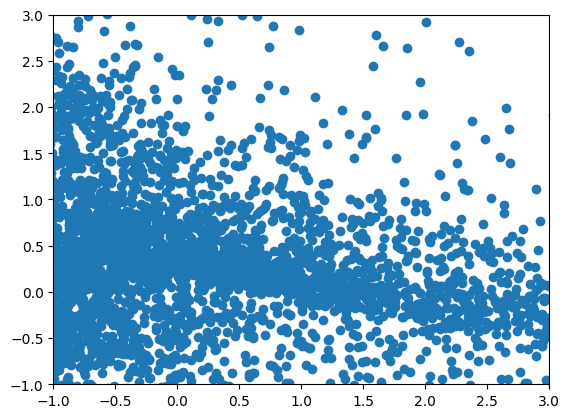

In [34]:
# let´s plot the transformed data along the different principal components 
x = X_train_scaled_pca[:,1]
y = X_train_scaled_pca[:,2]

plt.scatter(x,y)
plt.xlim(-1,3)
plt.ylim(-1,3)

# Use a nonlinear dimensionality reductiion method - tSNE

In [35]:
from sklearn.manifold import TSNE

X_embedded = TSNE(
    n_components=2, learning_rate='auto',
    init='random', perplexity=3).fit_transform(X_train_scaled)
X_embedded.shape

(5996, 2)

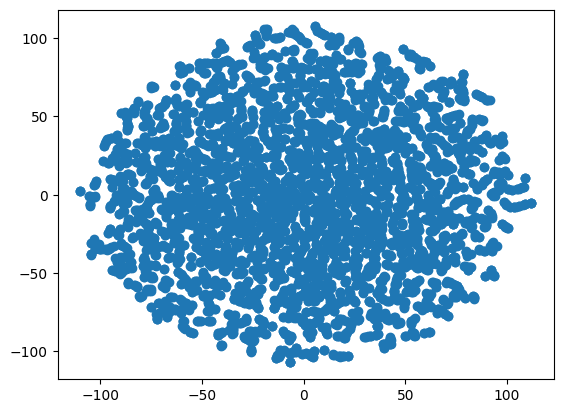

In [37]:
x = X_embedded[:,0]
y = X_embedded[:,1]

plt.scatter(x, y)



# Kmeans

In [33]:
X_train_scaled_pca.shape

(5996, 5)

In [34]:
icss = [] # inter-cluster sum of squares

range_values = range(1, 20)

for n in range_values:
  kmeans = KMeans(n_clusters = n)
  kmeans.fit(X_train_scaled_pca)
  icss.append(kmeans.inertia_) 

In [35]:
np.arange(1,20)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

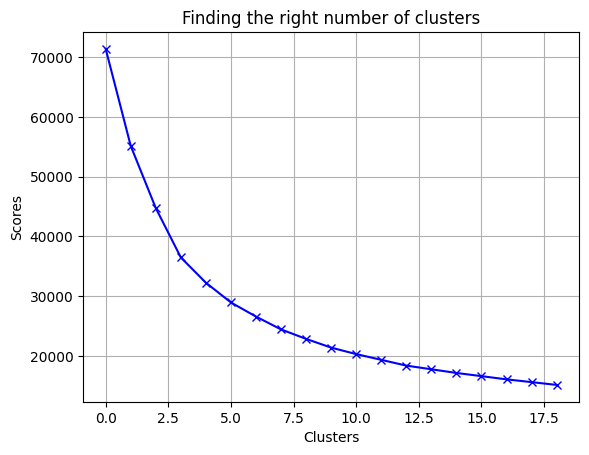

In [36]:
plt.plot(icss, 'bx-')
plt.title('Finding the right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('Scores')
plt.grid() 
plt.show()

# From this we can observe that, 4th cluster seems to be forming the elbow of the curve. 
# However, the values does not reduce linearly until 8th cluster. 
# Let's choose the number of clusters to be 7.

## Apply k-Means

In [37]:
# chooseing 6 clusters due to ellbow method
kmeans = KMeans(6)
kmeans.fit(X_train_scaled_pca)
labels = kmeans.labels_

In [39]:
kmeans.cluster_centers_.shape

(6, 5)

In [43]:
cluster_centers_pca = pd.DataFrame(
    data = kmeans.cluster_centers_, 
    columns = ['pc#1','pc#2','pc#3','pc#4','pc#5'],
    index = ['cluster#1','cluster#2','cluster#3','cluster#4','cluster#5','cluster#6'])
cluster_centers_pca           

,pc#1,pc#2,pc#3,pc#4,pc#5
cluster#1,0.597085,-1.302678,-1.035798,-0.365579,0.155092
cluster#2,-1.355374,-0.990421,1.352139,-0.462040,1.015700
cluster#3,3.358774,-0.253812,0.031643,0.149318,-0.622593
cluster#4,-1.150566,0.188082,0.234157,0.620726,-0.414146
cluster#5,-0.498325,3.732762,-0.467931,-0.596821,0.042824
cluster#6,12.014318,2.435640,3.989681,0.586520,1.590903


In [ ]:
# vizualize the centers of the clusters ie compress the n-dimensions to 2d



In [ ]:
# Plot the histogram of various clusters
for i in creditcard_df.columns:
  plt.figure(figsize = (35, 5))
  for j in range(8):
    plt.subplot(1,8,j+1)
    cluster = creditcard_df_cluster[creditcard_df_cluster['cluster'] == j]
    cluster[i].hist(bins = 20)
    plt.title('{}    \nCluster {} '.format(i,j))
  
  plt.show()

In [50]:
#lets look at the cluster centers in the original space!
cluster_centers = pd.DataFrame(
    data = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_)) , 
    columns = X_train.columns,
    index = ['cluster#1','cluster#2','cluster#3','cluster#4','cluster#5','cluster#6'])
cluster_centers

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster#1,694.615783,0.921212,816.816244,24.399231,793.010506,73.954061,0.842298,0.199952,0.757015,0.053085,1.026972,22.492448,3458.743409,629.721893,735.299911,0.279571,11.446792
cluster#2,-120.967585,0.538880,536.652204,326.027536,211.062488,463.731874,0.178066,-0.019536,0.130544,0.027764,-0.095461,-1.218931,3266.499192,1810.066997,232.008967,0.285891,11.023948
cluster#3,2100.600918,1.043525,3892.851867,2717.398556,1175.879776,382.712619,0.955047,0.600717,0.692705,0.068526,1.623257,48.074840,6714.270498,3636.089280,743.999793,0.250281,11.977250
cluster#4,1717.792006,0.903267,168.348848,278.779475,-110.488162,757.928449,0.264375,0.175401,0.105600,0.148177,2.904243,3.657802,3950.896120,703.921783,803.818247,0.003821,11.761576
cluster#5,4334.523608,0.987931,574.029624,307.842077,266.233709,4819.190861,0.248257,0.116418,0.176289,0.516043,15.784731,8.671109,6872.748016,4023.704535,1921.970852,-0.006080,11.091509
cluster#6,5653.422679,0.755232,13990.312604,10195.393748,3796.352323,2403.278744,1.169800,1.172690,0.816203,-0.037354,0.741774,121.553691,18002.474080,16227.108153,4025.717756,0.556769,12.795521


In [31]:
# In order to understand what these numbers mean, let's perform inverse transformation
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [creditcard_df.columns])
cluster_centers

# First Customers cluster (Transactors): Those are customers who pay least amount of intrerest charges and careful with their money, Cluster with lowest balance ($104) and cash advance ($303), Percentage of full payment = 23%
# Second customers cluster (revolvers) who use credit card as a loan (most lucrative sector): highest balance ($5000) and cash advance (~$5000), low purchase frequency, high cash advance frequency (0.5), high cash advance transactions (16) and low percentage of full payment (3%)
# Third customer cluster (VIP/Prime): high credit limit $16K and highest percentage of full payment, target for increase credit limit and increase spending habits
# Fourth customer cluster (low tenure): these are customers with low tenure (7 years), low balance 


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,776.924412,0.955729,910.919142,207.483460,703.871004,205.360364,0.880473,0.098390,0.825718,0.039552,0.770468,18.787037,3489.312964,1079.135079,637.014863,2.433989e-01,11.854776
1,103.490974,0.372267,347.264163,210.119722,137.394062,300.854201,0.270793,0.074946,0.188885,0.030585,0.676198,4.354920,3867.989440,1147.698560,263.699513,2.396728e-01,11.786375
2,5039.732557,0.970658,577.063595,349.992890,227.188243,5240.736449,0.310656,0.147945,0.206666,0.524751,16.650867,8.929480,8217.172885,4214.960237,1784.772963,4.024879e-02,11.602312
3,1859.830315,0.979136,3033.900653,2087.949772,946.422579,339.432336,0.929155,0.759589,0.578313,0.053967,1.093553,44.658019,7072.820183,2888.750005,754.176464,2.867398e-01,11.929245
4,861.385360,0.794488,395.941226,245.976624,150.442309,1116.114939,0.411243,0.121337,0.273164,0.195605,3.229299,5.133758,2465.787340,602.000784,375.834865,1.577381e-01,7.240446
5,1595.365208,0.972534,265.045078,216.853586,48.366485,777.827201,0.162345,0.101502,0.062941,0.154670,3.029349,3.094059,3415.016502,1024.540386,765.785049,2.128130e-02,11.880127
6,4425.362379,0.974886,16338.028250,11188.905375,5149.122875,1012.529590,0.924792,0.774489,0.774489,0.077083,2.512500,133.687500,12430.000000,16098.700812,2516.595215,4.066166e-01,11.962500
7,4250.150569,0.984849,918.267222,146.178056,772.089167,976.903069,0.499369,0.044823,0.468645,0.084596,2.833333,20.166667,4476.388889,1357.092339,27995.061876,5.551115e-17,11.916667


In [32]:
labels.shape # Labels associated to each data point

(8950,)

In [33]:
labels.max()

7

In [34]:
labels.min()

0

In [35]:
y_kmeans = kmeans.fit_predict(creditcard_df_scaled)
y_kmeans


array([0, 3, 5, ..., 6, 6, 6])

In [36]:
# concatenate the clusters labels to our original dataframe
creditcard_df_cluster = pd.concat([creditcard_df, pd.DataFrame({'cluster':labels})], axis = 1)
creditcard_df_cluster.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,5
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,2
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,3
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,5
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,5


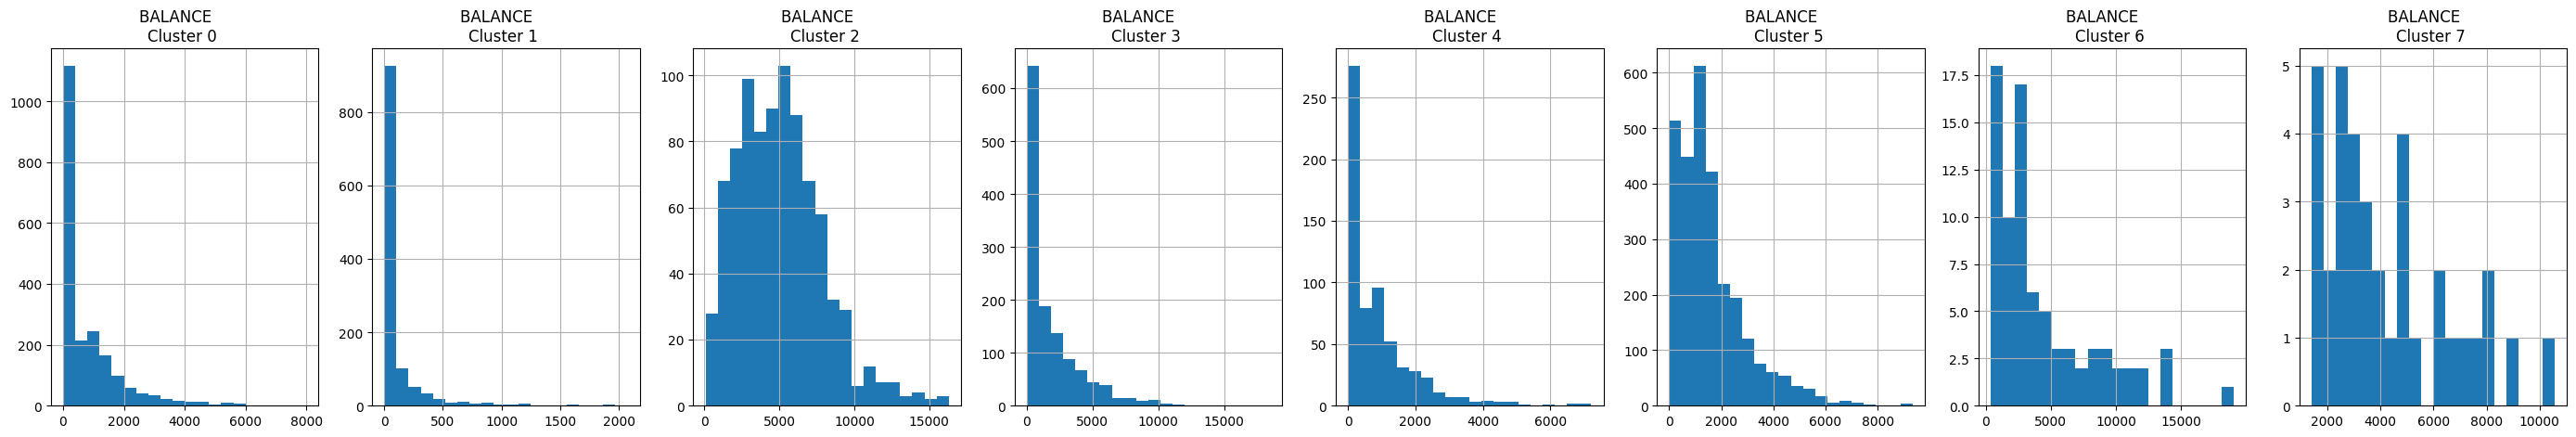

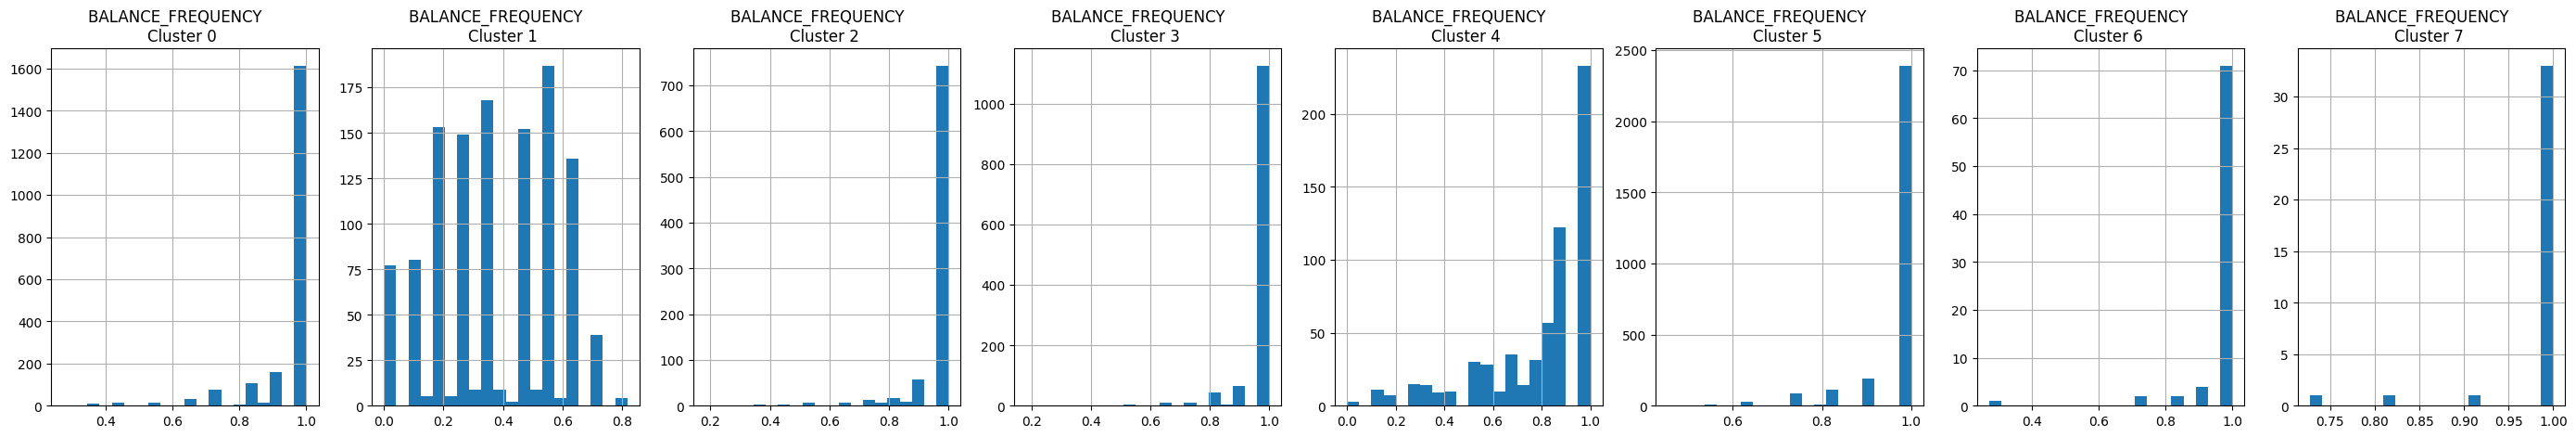

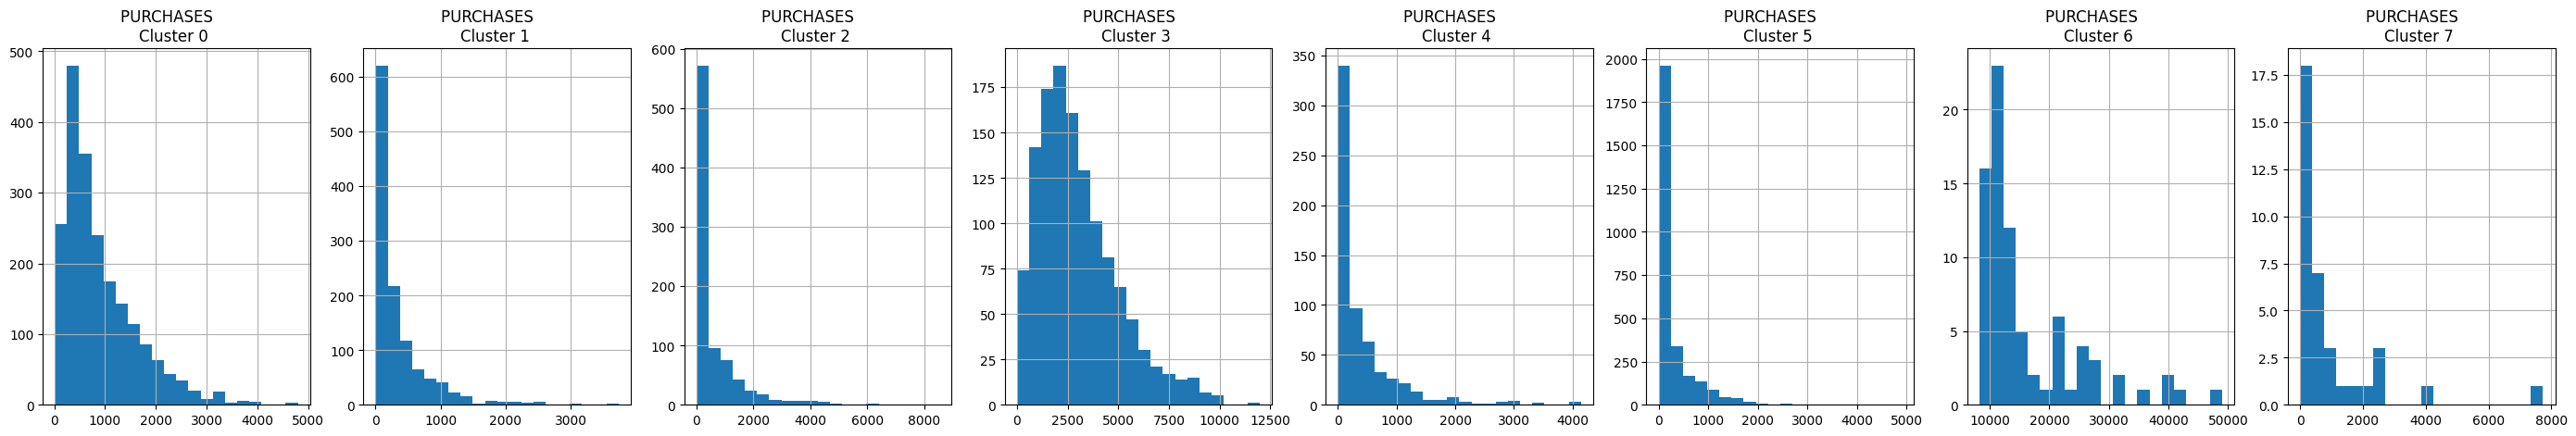

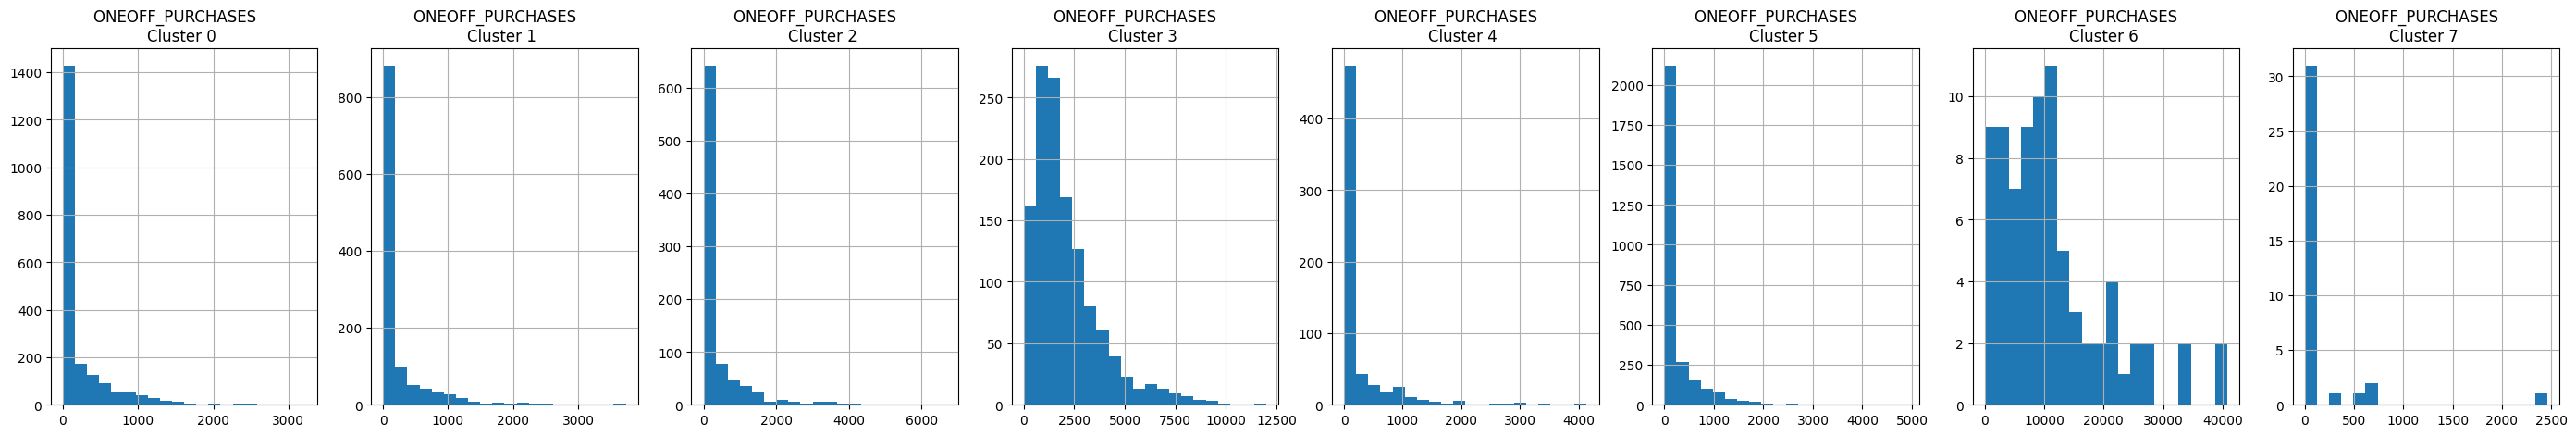

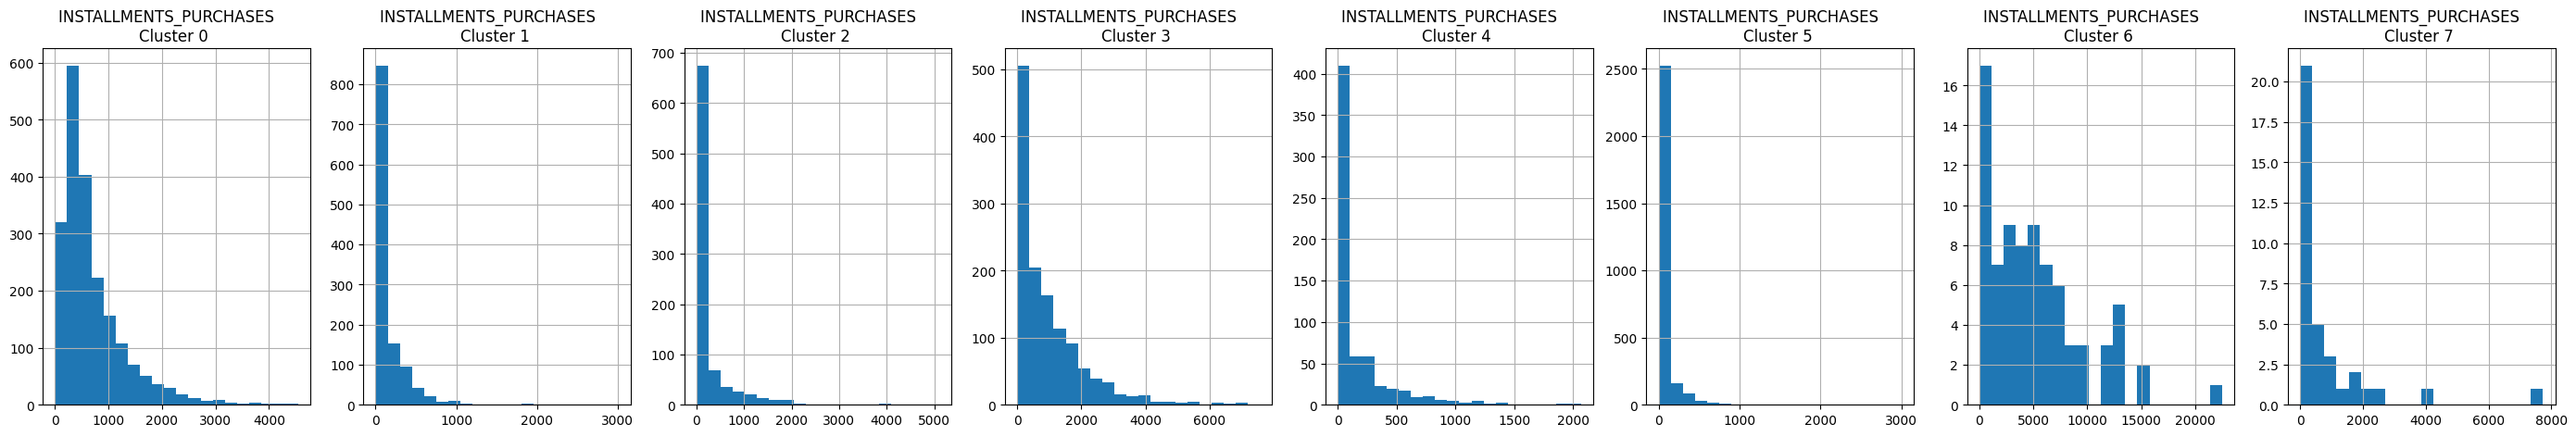

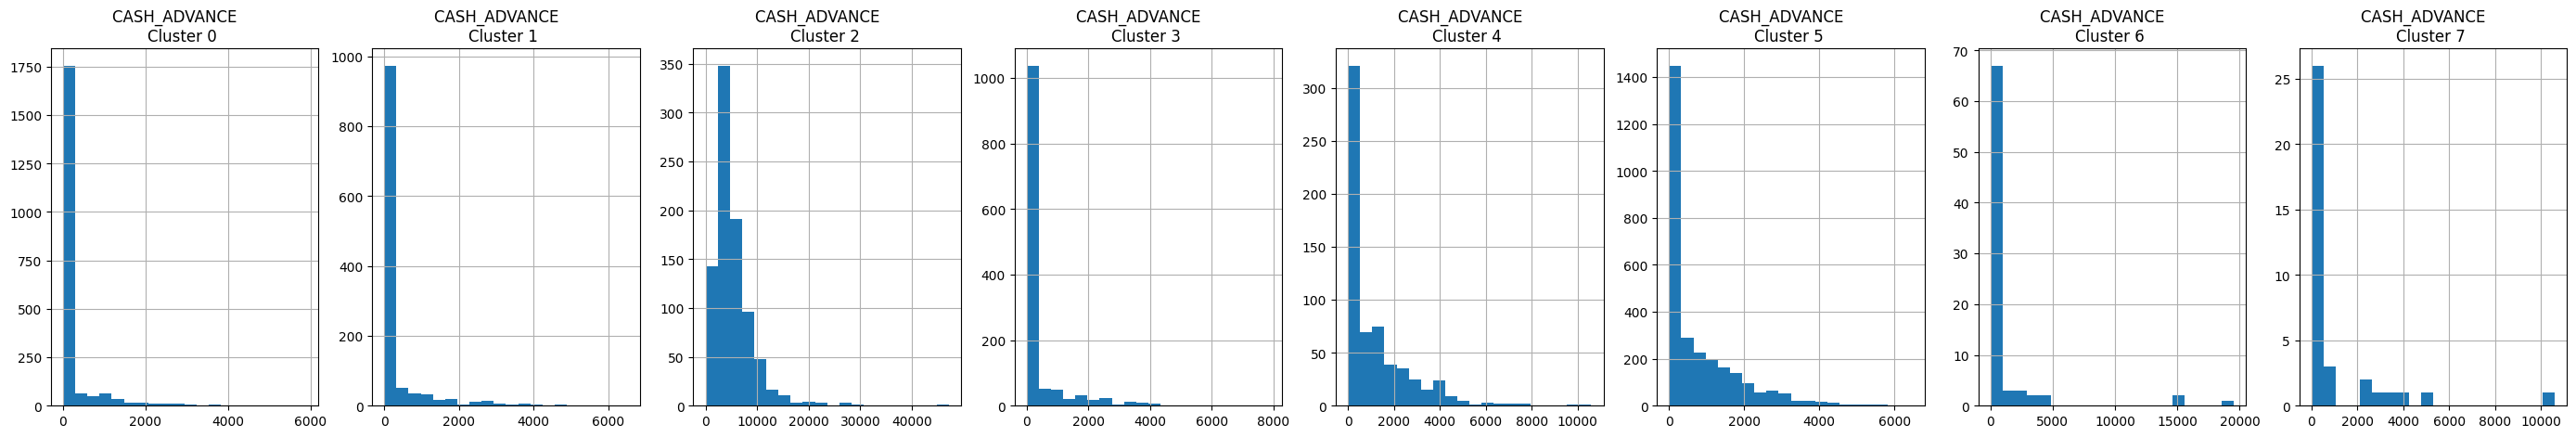

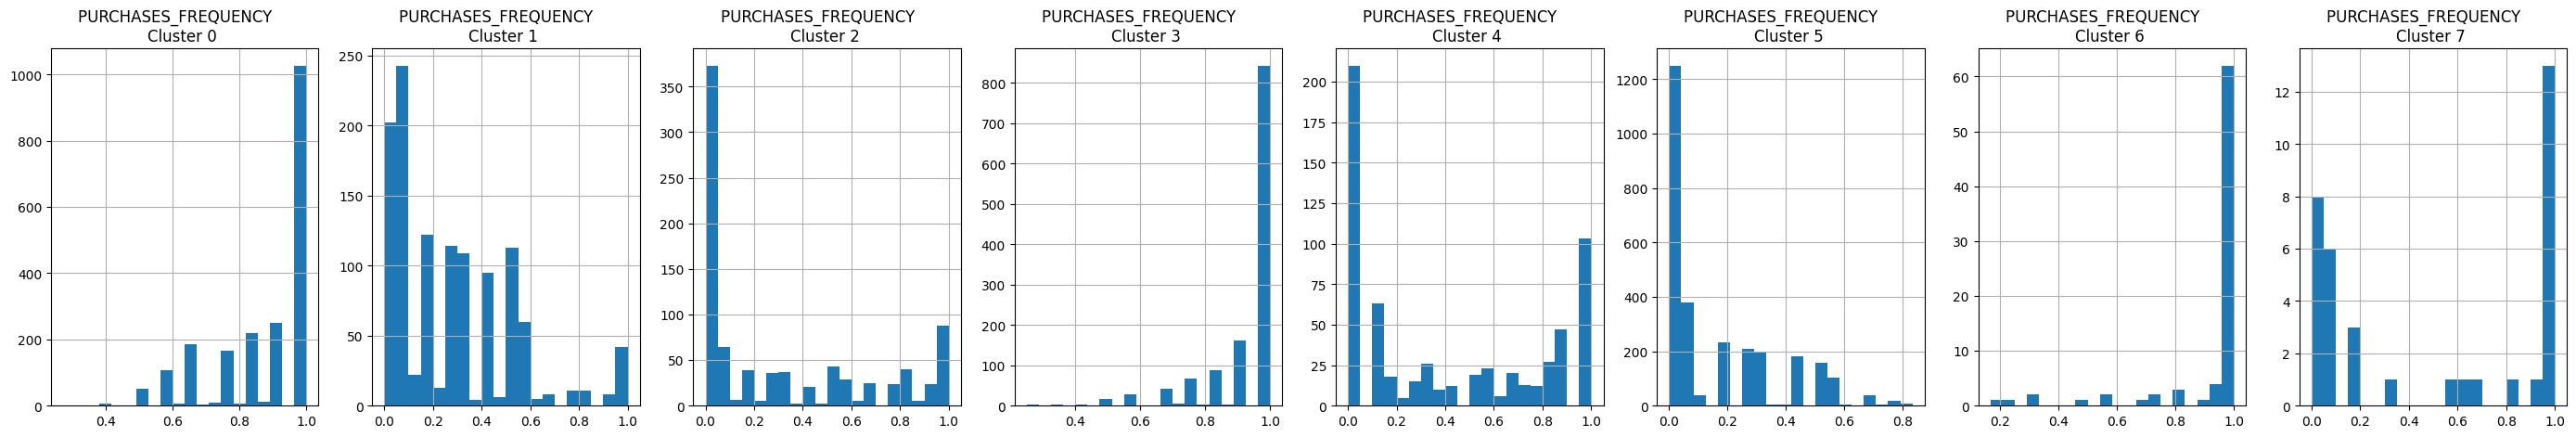

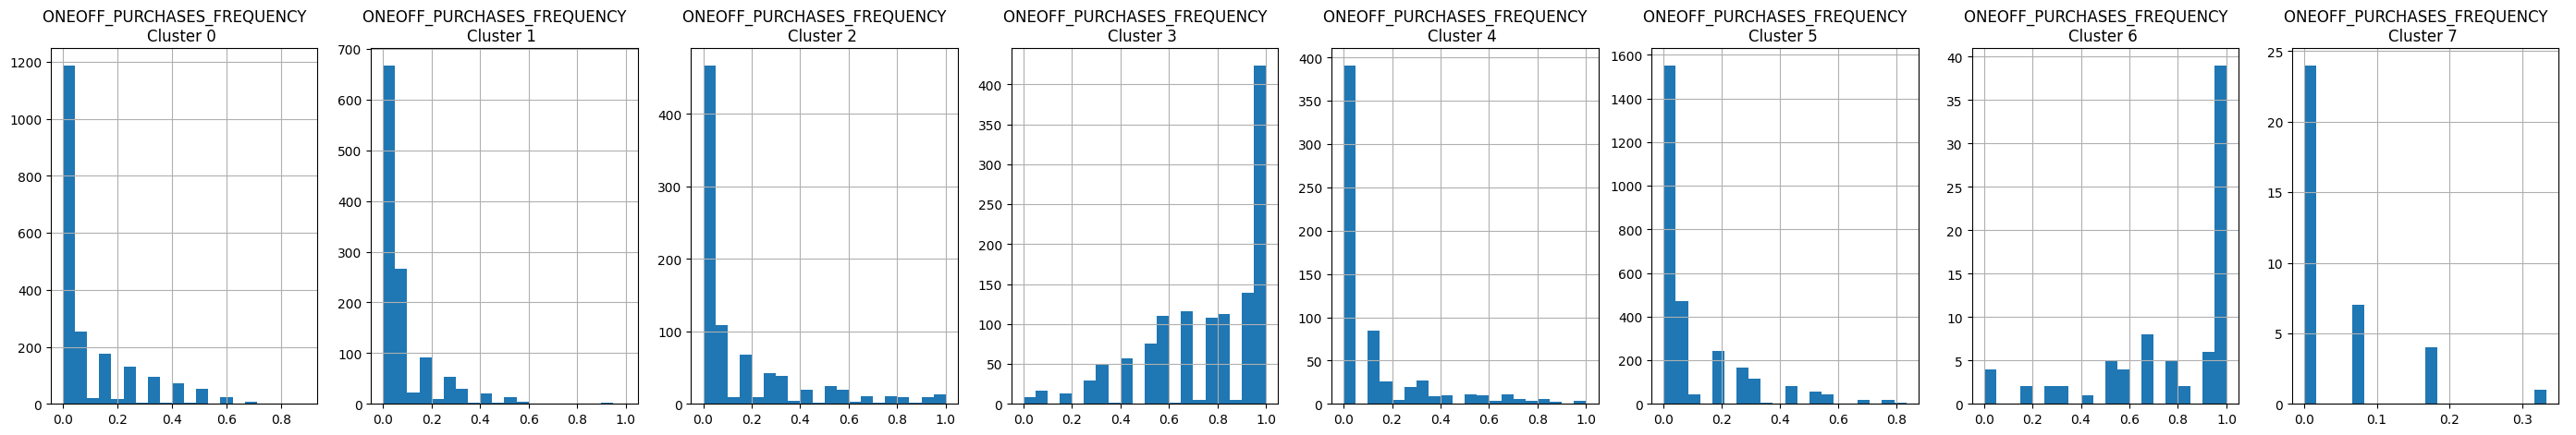

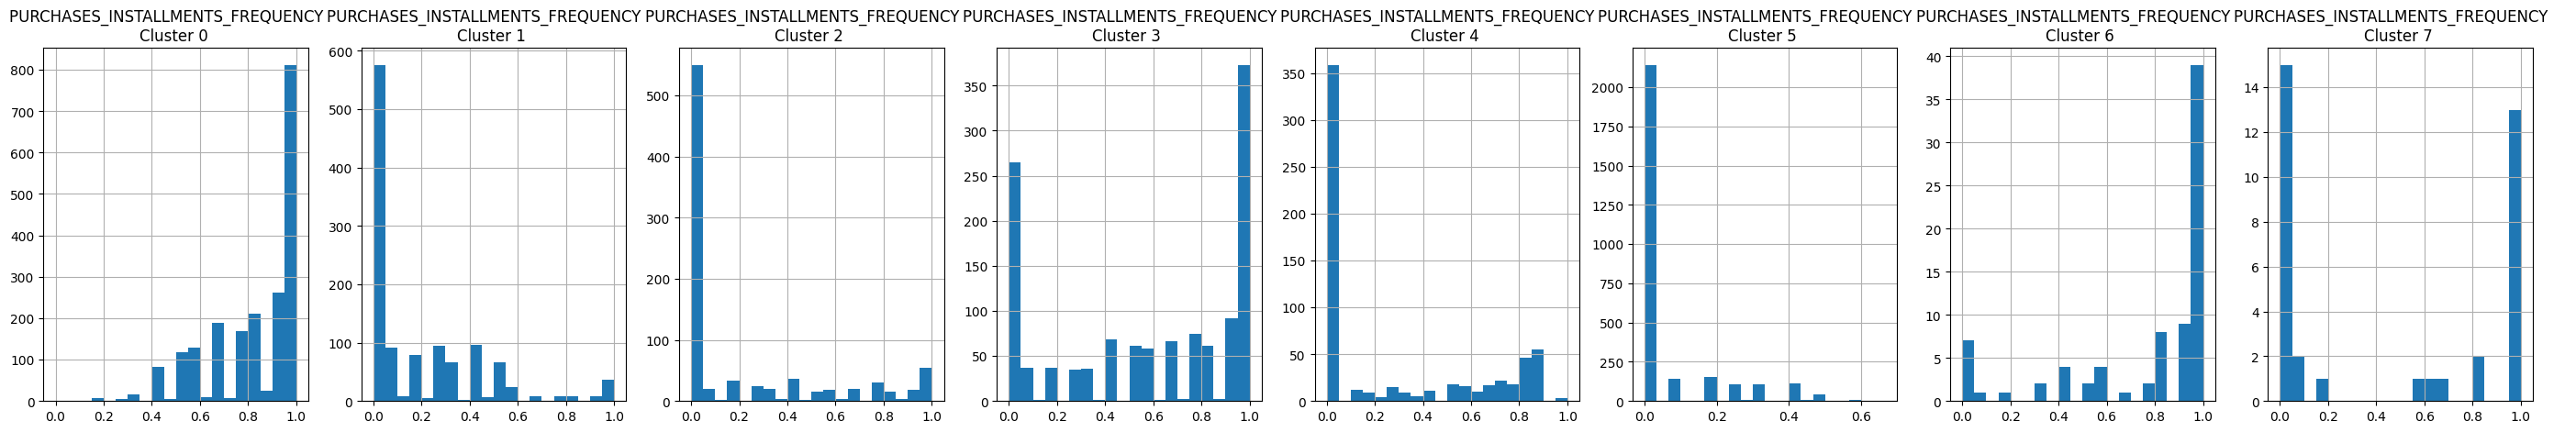

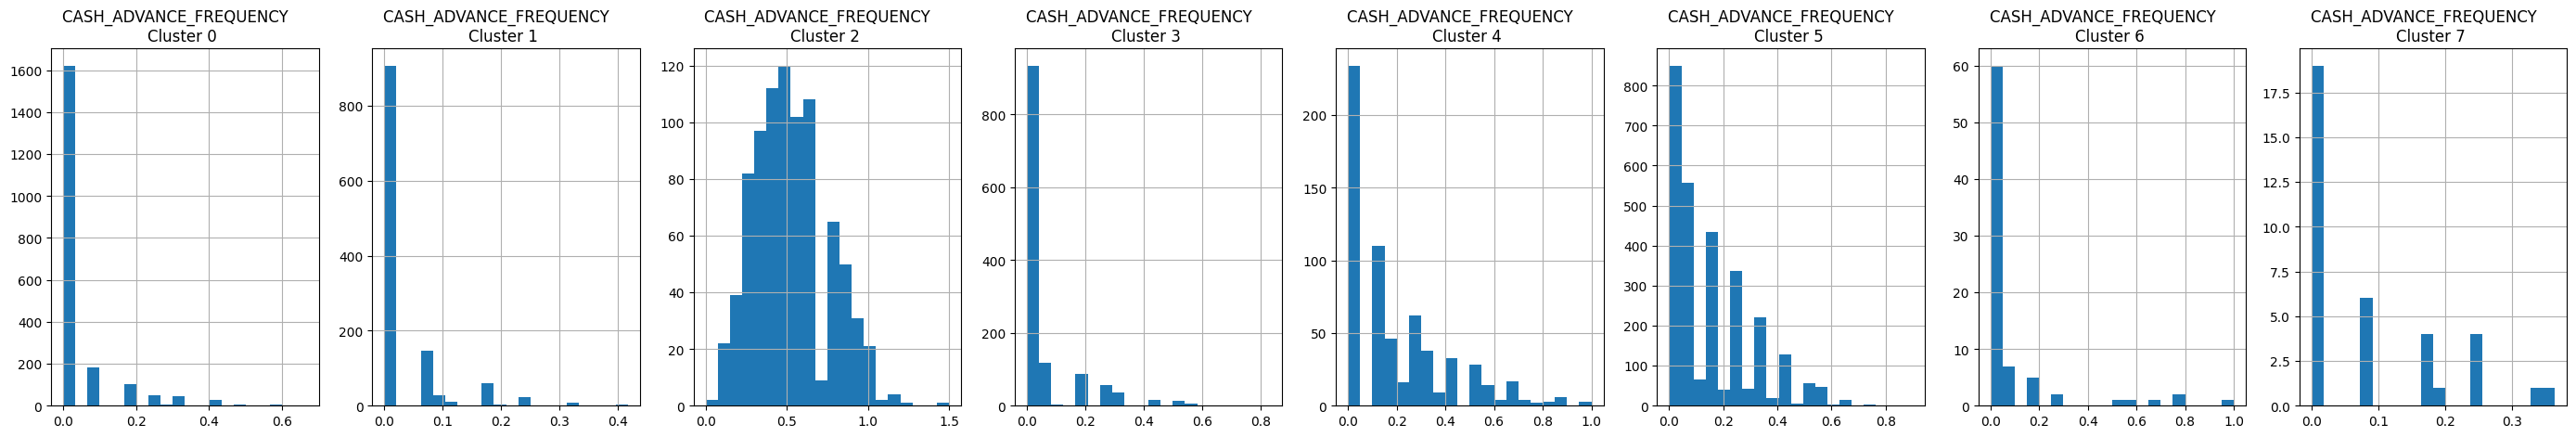

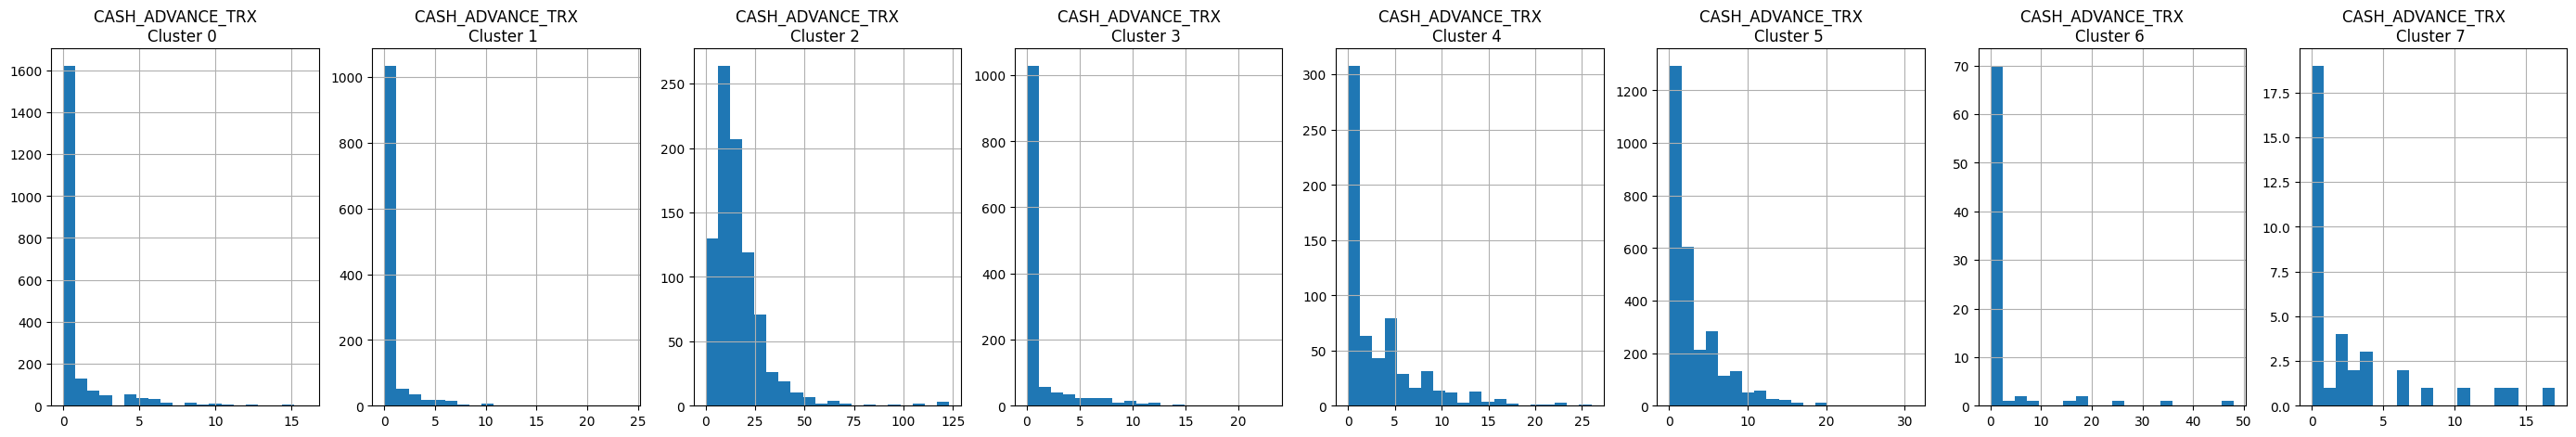

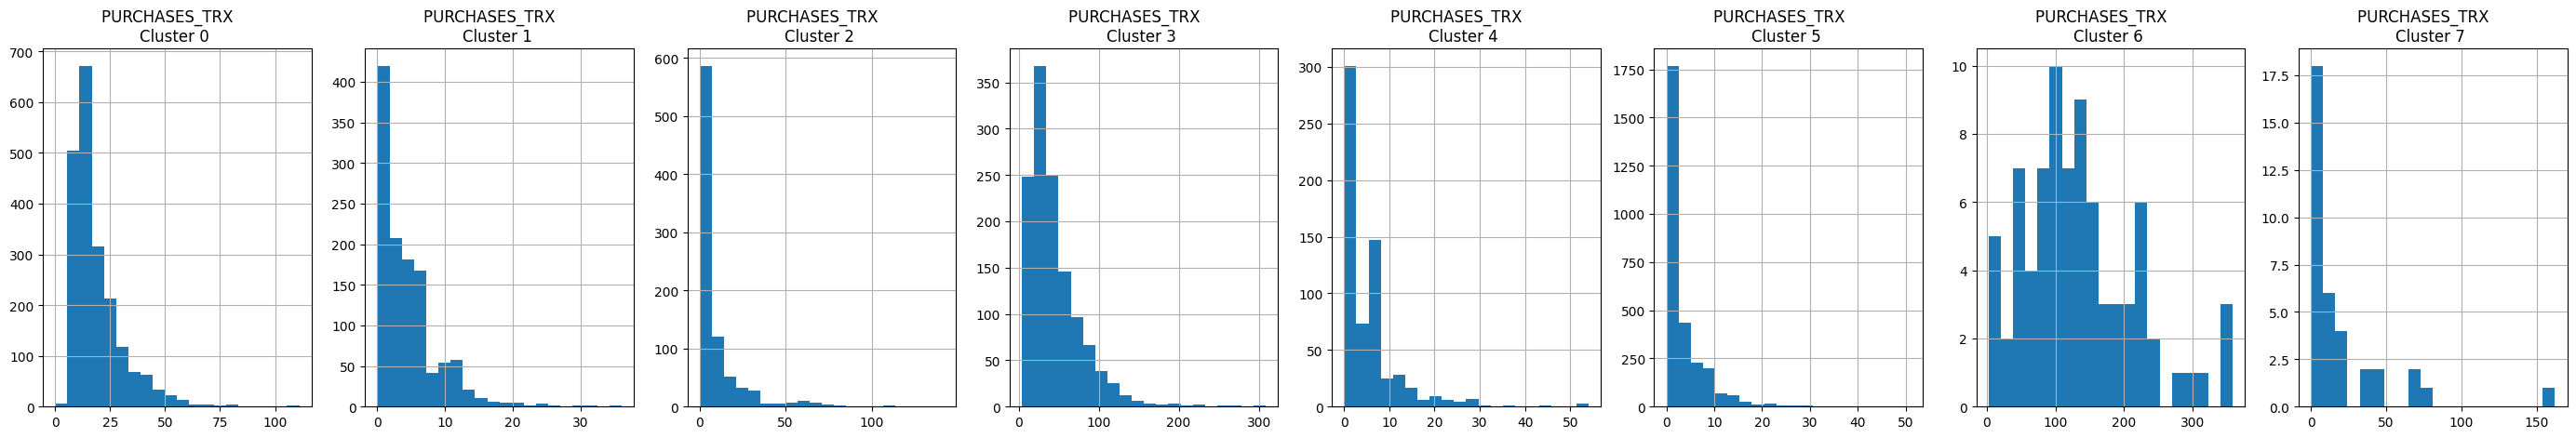

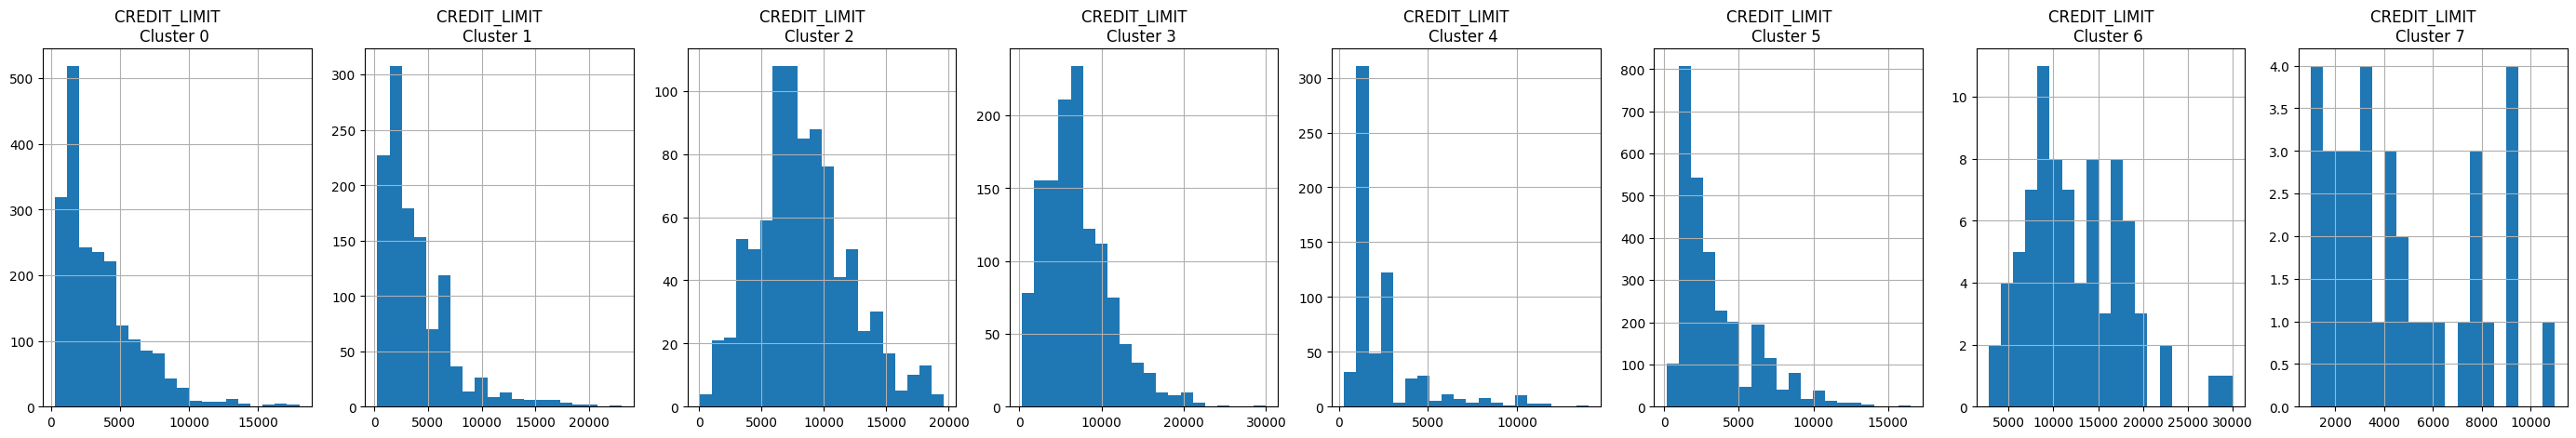

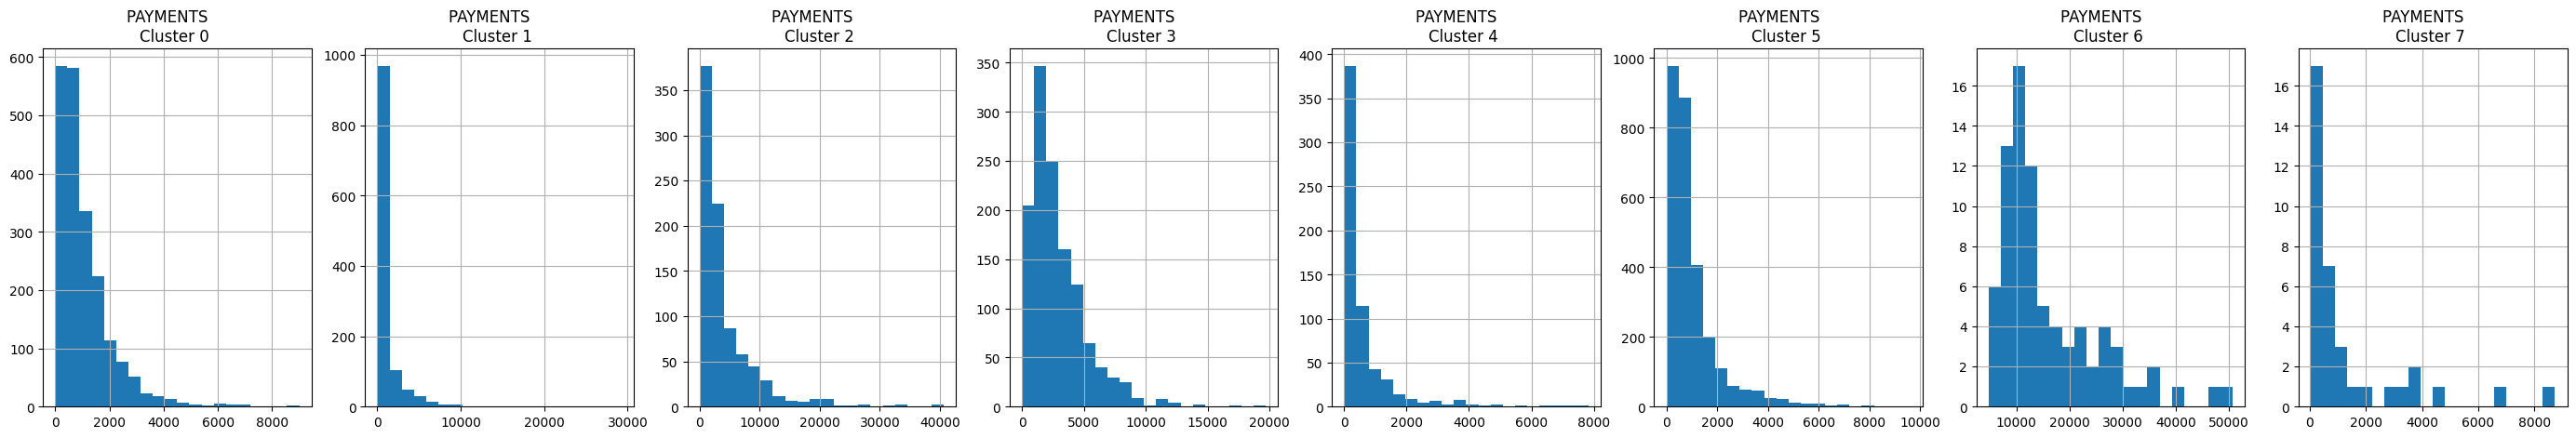

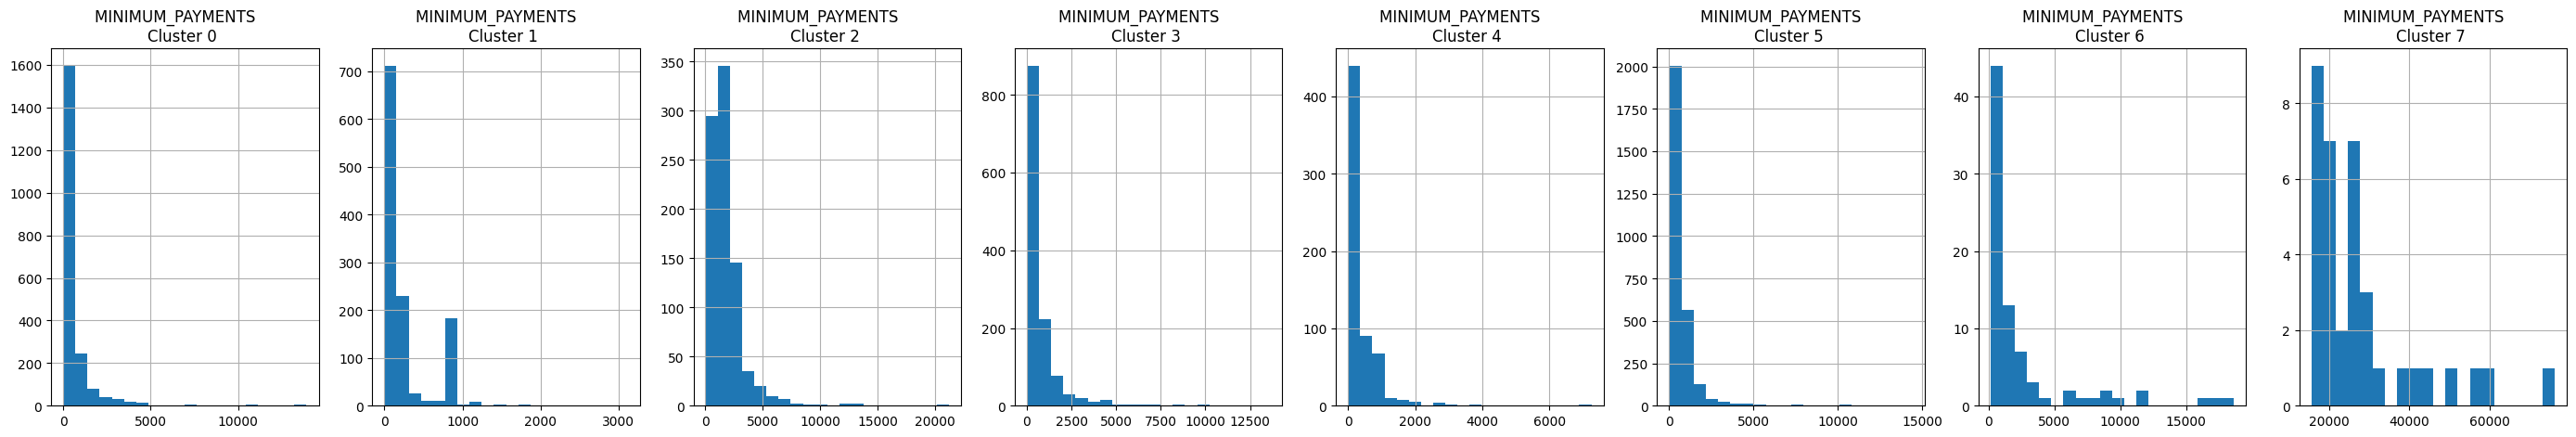

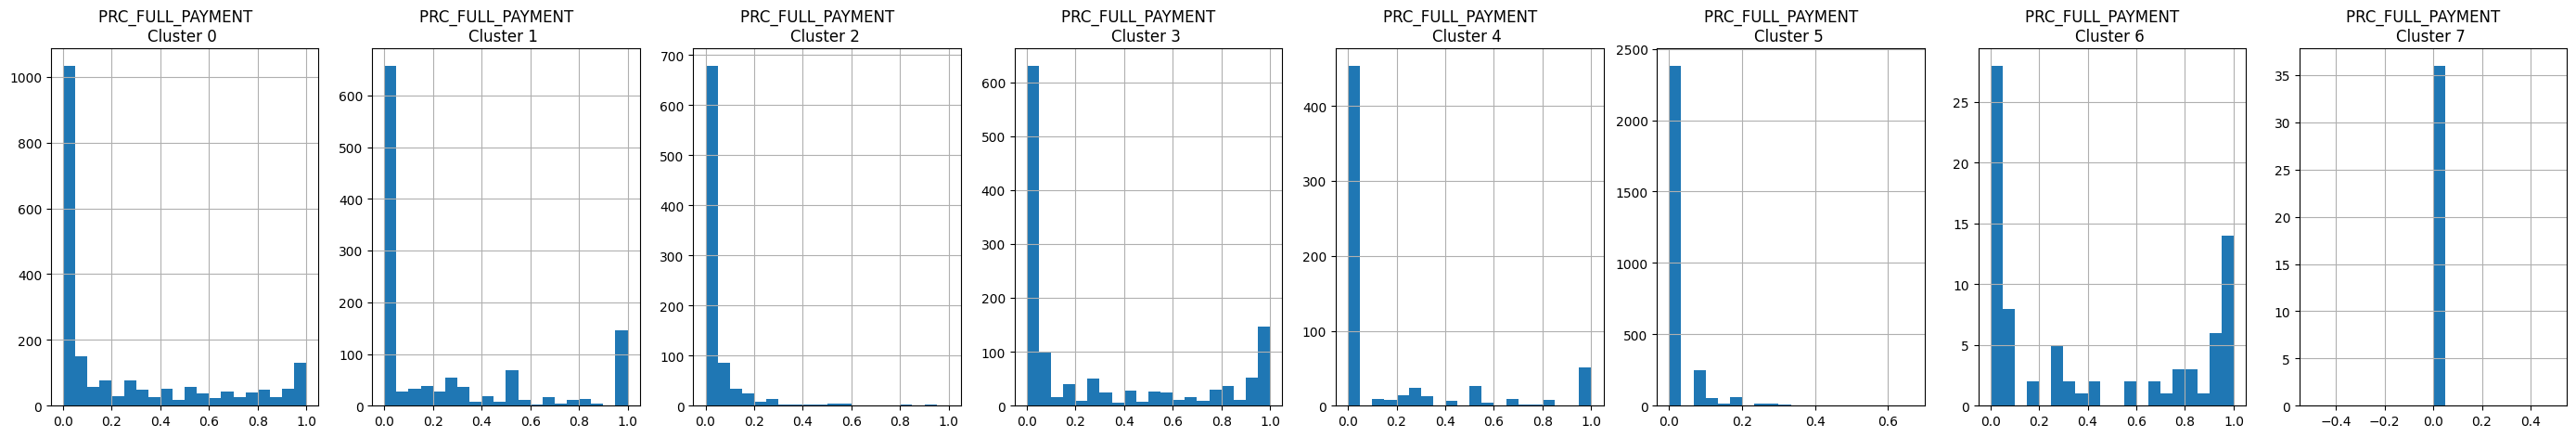

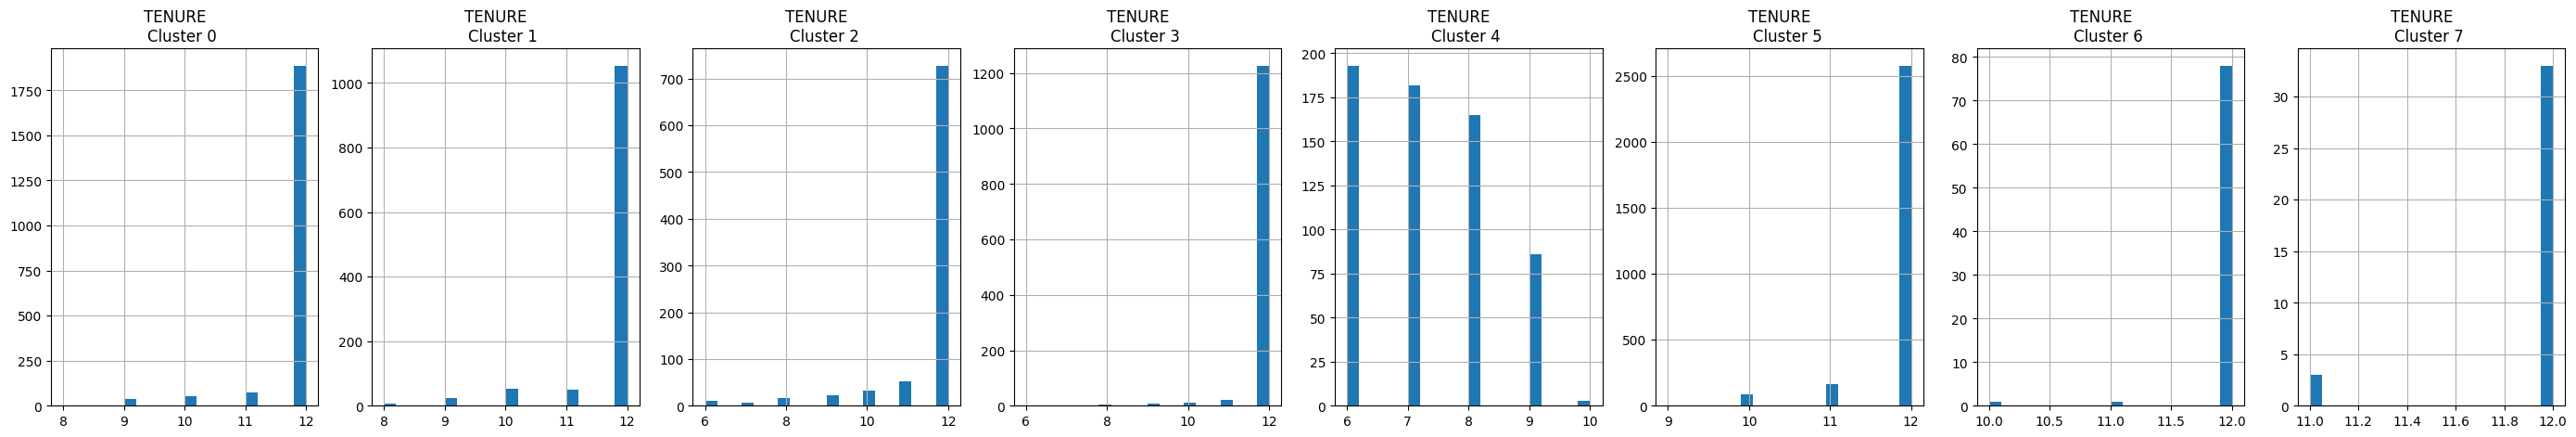

In [37]:
# Plot the histogram of various clusters
for i in creditcard_df.columns:
  plt.figure(figsize = (35, 5))
  for j in range(8):
    plt.subplot(1,8,j+1)
    cluster = creditcard_df_cluster[creditcard_df_cluster['cluster'] == j]
    cluster[i].hist(bins = 20)
    plt.title('{}    \nCluster {} '.format(i,j))
  
  plt.show()



# TASK 7: APPLY PRINCIPAL COMPONENT ANALYSIS AND VISUALIZE THE RESULTS

![alt text](https://drive.google.com/uc?id=1xDuvEnbuNqIjX5Zng39TCfGCf-BBDGf0)

In [38]:
# Obtain the principal components 
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(creditcard_df_scaled)
principal_comp

array([[-1.68221749, -1.07644828],
       [-1.13829099,  2.50648888],
       [ 0.96967918, -0.38351885],
       ...,
       [-0.92620224, -1.81078955],
       [-2.33654412, -0.6579702 ],
       [-0.55642172, -0.40047032]])

In [39]:
# Create a dataframe with the two components
pca_df = pd.DataFrame(data = principal_comp, columns =['pca1','pca2'])
pca_df.head()

,pca1,pca2
0,-1.682217,-1.076448
1,-1.138291,2.506489
2,0.969679,-0.383519
3,-0.873628,0.043174
4,-1.599431,-0.688582


In [40]:
# Concatenate the clusters labels to the dataframe
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()

,pca1,pca2,cluster
0,-1.682217,-1.076448,5
1,-1.138291,2.506489,2
2,0.969679,-0.383519,3
3,-0.873628,0.043174,5
4,-1.599431,-0.688582,5


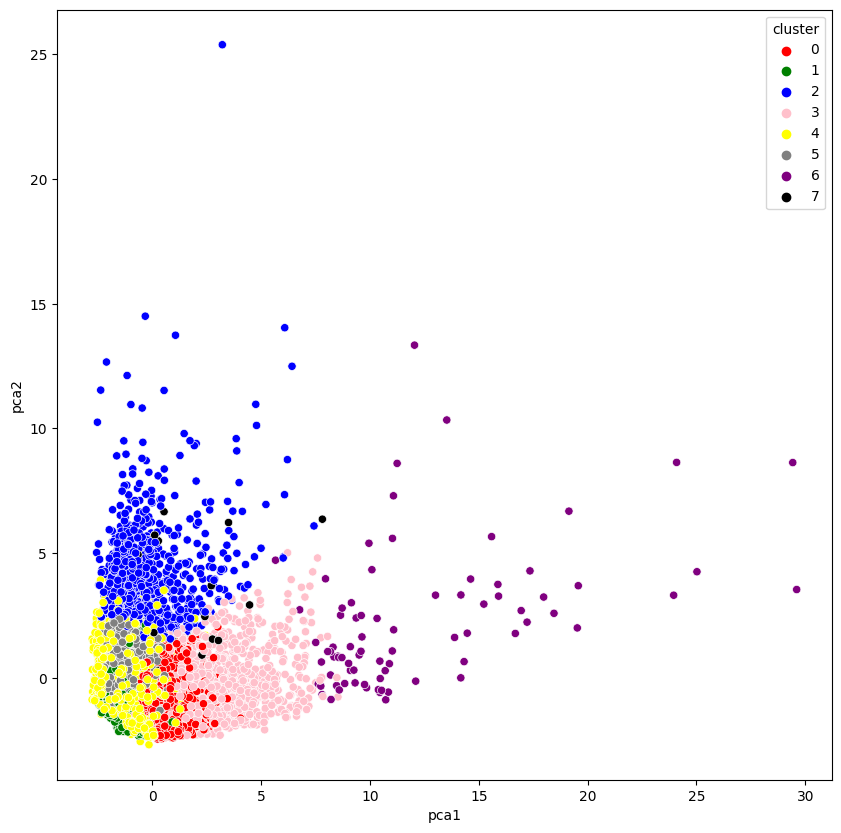

In [41]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="pca1", 
                     y="pca2", 
                     hue = "cluster", 
                     data = pca_df, 
                     palette =['red','green','blue','pink','yellow','gray','purple', 'black'])
plt.show()

# TASK #8: UNDERSTAND THE THEORY AND INTUITION BEHIND AUTOENCODERS

![alt text](https://drive.google.com/uc?id=1g0tWKogvKaCrtsfzjApi6m8yGD3boy4x)

![alt text](https://drive.google.com/uc?id=1AcyUL_F9zAD2--Hmyq9yTkcA9mC6-bwg)

![alt text](https://drive.google.com/uc?id=1xk1D5uldId0DWywRJ3-OAVBcIr5NGCq_)

# TASK #9: APPLY AUTOENCODERS (PERFORM DIMENSIONALITY REDUCTION USING AUTOENCODERS)

In [42]:
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from keras.optimizers import SGD

encoding_dim = 7

input_df = Input(shape=(17,))


# Glorot normal initializer (Xavier normal initializer) draws samples from a truncated normal distribution 

x = Dense(encoding_dim, activation='relu')(input_df)
x = Dense(500, activation='relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation='relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation='relu', kernel_initializer = 'glorot_uniform')(x)

encoded = Dense(10, activation='relu', kernel_initializer = 'glorot_uniform')(x)

x = Dense(2000, activation='relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(500, activation='relu', kernel_initializer = 'glorot_uniform')(x)

decoded = Dense(17, kernel_initializer = 'glorot_uniform')(x)

# autoencoder
autoencoder = Model(input_df, decoded)

#encoder - used for our dimention reduction
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer= 'adam', loss='mean_squared_error')


In [43]:
creditcard_df_scaled.shape

(8950, 17)

In [44]:
autoencoder.fit(creditcard_df_scaled, creditcard_df_scaled, batch_size = 128, epochs = 25,  verbose = 1)

Epoch 1/25
70/70 [==============================] - 2s 24ms/step - loss: 0.5183
Epoch 2/25
70/70 [==============================] - 2s 27ms/step - loss: 0.2942
Epoch 3/25
70/70 [==============================] - 2s 26ms/step - loss: 0.2110
Epoch 4/25
70/70 [==============================] - 2s 28ms/step - loss: 0.1753
Epoch 5/25
70/70 [==============================] - 2s 24ms/step - loss: 0.1575
Epoch 6/25
70/70 [==============================] - 2s 26ms/step - loss: 0.1297
Epoch 7/25
70/70 [==============================] - 2s 23ms/step - loss: 0.1155
Epoch 8/25
70/70 [==============================] - 2s 23ms/step - loss: 0.1023
Epoch 9/25
70/70 [==============================] - 2s 24ms/step - loss: 0.0959
Epoch 10/25
70/70 [==============================] - 2s 24ms/step - loss: 0.0857
Epoch 11/25
70/70 [==============================] - 2s 23ms/step - loss: 0.0804
Epoch 12/25
70/70 [==============================] - 2s 23ms/step - loss: 0.0774
Epoch 13/25
70/70 [==================

In [45]:
autoencoder.save_weights('autoencoder.h5')

In [46]:
pred = encoder.predict(creditcard_df_scaled)

280/280 [==============================] - 1s 4ms/step


In [47]:
pred.shape

(8950, 10)

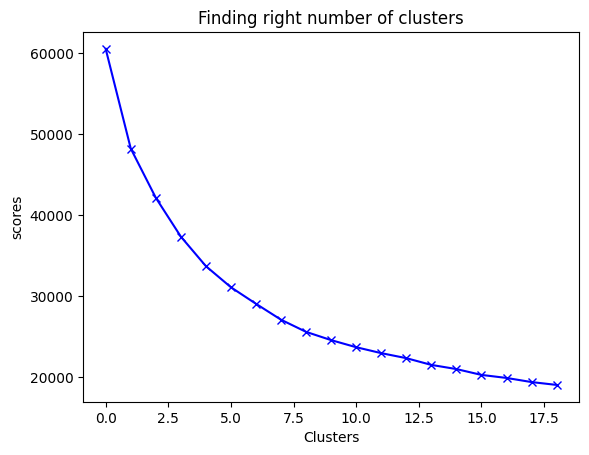

In [48]:
scores_2 = []

range_values = range(1, 20)

for i in range_values:
  kmeans = KMeans(n_clusters= i)
  kmeans.fit(pred)
  scores_2.append(kmeans.inertia_)

plt.plot(scores_2, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores') 
plt.show()

C:\Users\Sebas\AppData\Local\Temp\ipykernel_13860\3412112664.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(scores_1, 'bx-', color = 'r')
C:\Users\Sebas\AppData\Local\Temp\ipykernel_13860\3412112664.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(scores_2, 'bx-', color = 'g')


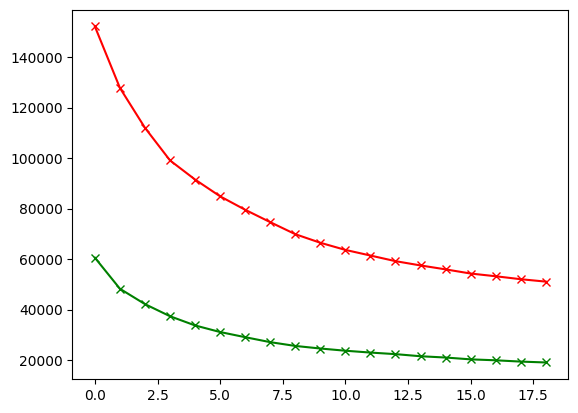

In [49]:
plt.plot(scores_1, 'bx-', color = 'r')
plt.plot(scores_2, 'bx-', color = 'g')
plt.show()

In [50]:
kmeans = KMeans(4)
kmeans.fit(pred)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(creditcard_df_scaled)

In [51]:
df_cluster_dr = pd.concat([creditcard_df, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster_dr.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,3
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,2
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,3
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,2
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,3


In [52]:
pca = PCA(n_components=2)
prin_comp = pca.fit_transform(pred)
pca_df = pd.DataFrame(data = prin_comp, columns =['pca1','pca2'])
pca_df.head()

,pca1,pca2
0,-1.447780,-0.388865
1,-0.210583,1.434421
2,-0.034225,-0.372748
3,-0.002271,0.707299
4,-1.506098,-0.229489


In [53]:
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()

,pca1,pca2,cluster
0,-1.447780,-0.388865,3
1,-0.210583,1.434421,2
2,-0.034225,-0.372748,3
3,-0.002271,0.707299,2
4,-1.506098,-0.229489,3


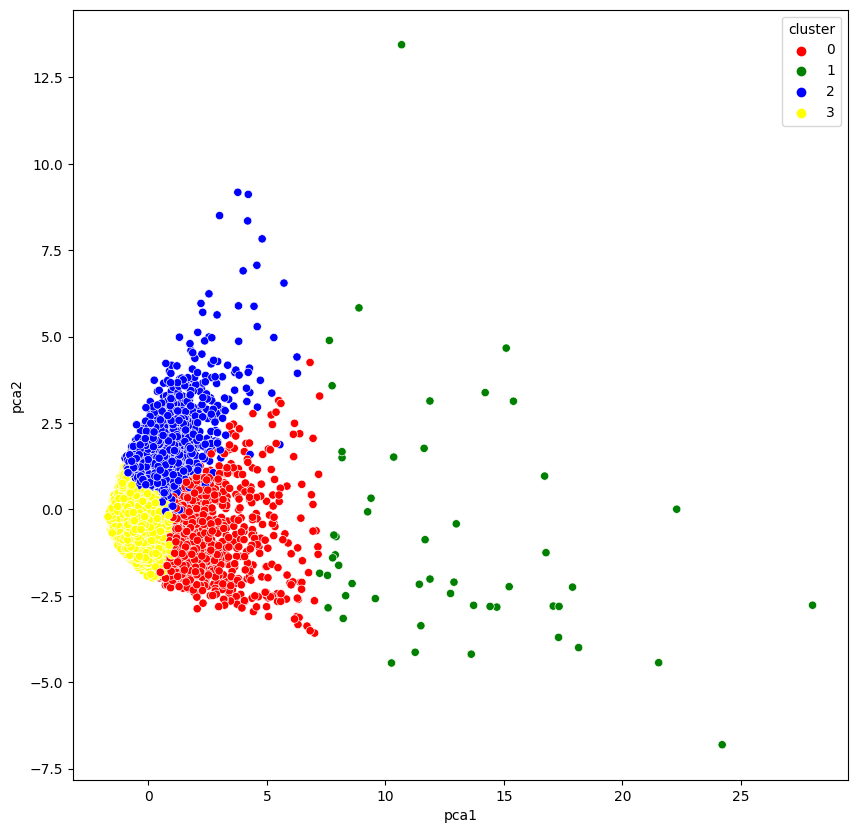

In [54]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="pca1", y="pca2", hue = "cluster", data = pca_df, palette =['red','green','blue','yellow'])
plt.show()

# Testing